# Проект. HR-аналитика

**Цель исследования** - Разработать и внедрить модели машинного обучения для прогнозирования уровня удовлетворённости сотрудников работой и вероятности их увольнения на основе данных о характеристиках сотрудников компании «Работа с заботой».

**Задачи исследования**:

1) Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

2) Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


**План исследования**:

***Задача 1***

1. **Загрузка данных.** Загрузить данные и убедиться в наличии всех признаков указанных в задании.
2. **Предобработка данных.** Провести предобработку данных.
3. **Исследовательский анализ данных.** Исследовать все признаки и сделать вывод о том как их подготовить

4. **Подготовка данных** Подготовить признаки в пайплайне. Использовать в пайплайне шаг предобработки

5. **Обучение моделей** Обучить как минимум две модели. Выбор лучшей модели произвести на основе метрики SMAPE.

6. **Оформление выводов**

***Задача 2***

1. **Загрузка данных.** Загрузить данные и убедиться в наличии всех признаков указанных в задании.
2. **Предобработка данных.** Изучить данные и выполнить предобработку.
3. **Исследовательский анализ данных**
    * 3.1 Провести исследовательский анализ
    * 3.2 Составить портрет уволившегося сотрудника
    * 3.3 Проверить гипотезу о том,что уровень удовлетворенности сотрудника работой влияет на уволнения
    
    
4. **Добавление признака** Добавить в качестве входного признака job_satisfaction_rate предсказанное моделью из первой задачи
5. **Подготовка данных** Выполнить предобрабработку признаков в пайплайне
6. **Обучение модели** Обучить как минимум три модели. Оценить качество лучшей модели с помощью мерики roc-auc
7. **Оформление выводов**

## Предсказание уровня удовлетворённости сотрудника.

### Загрузка данных

Импортируем необходимые в проекте библиотеки

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor,DummyClassifier
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer,roc_auc_score
import shap
from scipy import stats as st

Загрузим тренировочную выборку для первой задачи

In [75]:
df_train_job = pd.read_csv('data/train_job_satisfaction_rate_fixed.csv')

In [76]:
df_train_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Выведем общую информацию о таблице

In [77]:
df_train_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Данные таблицы корректно загружены. Признаки соответсвуют описанию

Загрузим данные тестовой выборки

In [78]:
df_test_features = pd.read_csv('data/test_features.csv')

In [79]:
df_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Выведем общую информацию о датасете

In [80]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Данные таблица корректно загружены. Признаки соответствуют описанию

Загрузим данные тестовой выборки с целевым признаком

In [81]:
df_test_target_job = pd.read_csv('data/test_target_job_satisfaction_rate.csv')

In [82]:
df_test_target_job.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [83]:
df_test_target_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Вывод**

Все данные для первой задачи были успешно загружены

### Предобработка данных

#### Предобработка данных тренировочного датасета первой задачи

**Анализ талицы на наличие пропусков**

In [84]:
df_train_job.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

В таблице существуют пропуски. Заполним их на этапе подготовки данных к моделированию.

**Анализ таблицы на наличие дубликатов**

In [85]:
df_train_job.duplicated().sum()

0

В таблице отсутсвуют дубликаты

**Анализ таблицы на наличие неявных дубликатов**

Проанализируем нечисловые столбцы на наличие неявных дубликатов

In [86]:
columns = ['dept','level','workload','last_year_promo','last_year_violations']

for i in columns:
    print(f'Уникальные значения в колонке {i}: {df_train_job[i].unique()}')

Уникальные значения в колонке dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения в колонке level: ['junior' 'middle' 'senior' nan]
Уникальные значения в колонке workload: ['medium' 'high' 'low']
Уникальные значения в колонке last_year_promo: ['no' 'yes']
Уникальные значения в колонке last_year_violations: ['no' 'yes']


В таблице отсутствуют неявные дубликаты

Исправим грамматическую ошибку в столбце level

In [87]:
df_train_job['level'] = df_train_job['level'].replace('sinior', 'senior')

**Изменение индексов таблицы**

Присвоим индексы теблице из столбца "id"

In [88]:
df_train_job = df_train_job.set_index('id')

In [89]:
df_train_job.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


#### Предобработка данных тестового датасета первой задачи

**Анализ таблицы на наличие пропусков**

In [90]:
df_test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

В таблице присутствуют пропуски. Обработаем их на этапе подготовки данных

**Анализ таблицы на наличие дубликатов**

In [91]:
df_test_features.duplicated().sum()

0

В таблице отсутсвуют дубликаты

**Анализ таблицы на наличие неявных дубликатов**

In [92]:
columns = ['dept','level','workload','last_year_promo','last_year_violations']

for i in columns:
    print(f'Уникальные значения в колонке {i}: {df_test_features[i].unique()}')

Уникальные значения в колонке dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в колонке level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в колонке workload: ['medium' 'low' 'high' ' ']
Уникальные значения в колонке last_year_promo: ['no' 'yes']
Уникальные значения в колонке last_year_violations: ['no' 'yes']


Заменим значения " " в колонках dept и workload на np.nan. Последующей обработкой пропусков займёмся на этапе подготовки данных

In [93]:
df_test_features['dept'] = df_test_features['dept'].replace(' ', np.nan)
df_test_features['workload'] = df_test_features['workload'].replace(' ',np.nan)

for i in ['dept','workload']:
    print(f'Уникальные значения в столбце {i}: {df_test_features[i].unique()}')

Уникальные значения в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения в столбце workload: ['medium' 'low' 'high' nan]


Исправим грамматическую ошибку в столбце level

In [94]:
df_test_features['level'] = df_test_features['level'].replace('sinior', 'senior')

Замена прошла успешно

**Изменение индексов таблицы**

Изменим индексы таблицы на id клиентов

In [95]:
df_test_features = df_test_features.set_index('id')

In [96]:
df_test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


#### Обработка данных с целевым признаком тестовой выборки для первой задачи

In [97]:
df_test_target_job.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**Анализ данных на наличие пропусков**

In [98]:
df_test_target_job.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

В таблице отсутсвуют пропуски

**Анализ таблицы на наличие дубликатов**

In [99]:
df_test_target_job.duplicated().sum()

0

В таблице отсутствуют дубликаты

**Изменение индексов таблицы**

Изменим индексы таблицы на индексы работников

In [100]:
df_test_target_job = df_test_target_job.set_index('id')

In [101]:
df_test_target_job.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


**Вывод** 

Таблицы были проанализированы на наличие пропусков, дубликатов и неявных дубликатов. Были устранены проблемы в данных. 

### Исследовательский анализ данных

#### Исследование тренировочного датасета

Исследуем количественные признаки тренировочного датасета

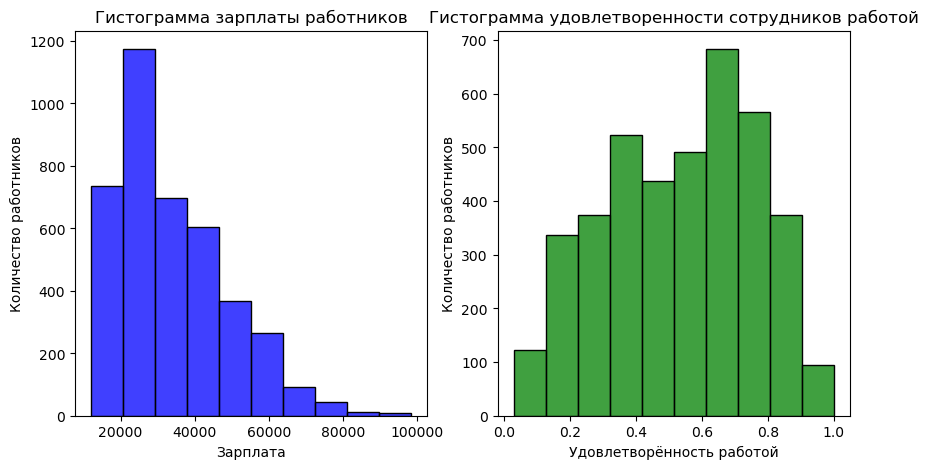

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(df_train_job['salary'],ax=ax[0],color='b',bins=10)
ax[0].set_xlabel('Зарплата')
ax[0].set_ylabel('Количество работников')
ax[0].set_title('Гистограмма зарплаты работников')

sns.histplot(df_train_job['job_satisfaction_rate'],ax=ax[1],color='g',bins=10)
ax[1].set_xlabel('Удовлетворённость работой')
ax[1].set_ylabel('Количество работников')
ax[1].set_title('Гистограмма удовлетворенности сотрудников работой')
plt.show()

* Гистограмма зарплат сотрудников представляет собой унимодальное распределение, напоминающее нормальное, с смещением влево.
* Гистограмма уровня удовлетворенности сотрудников работой представляет собой унимодальное распределение, напоминающее нормальное, с смещением вправо.

Проанализируем столбцы на наличие выбросов

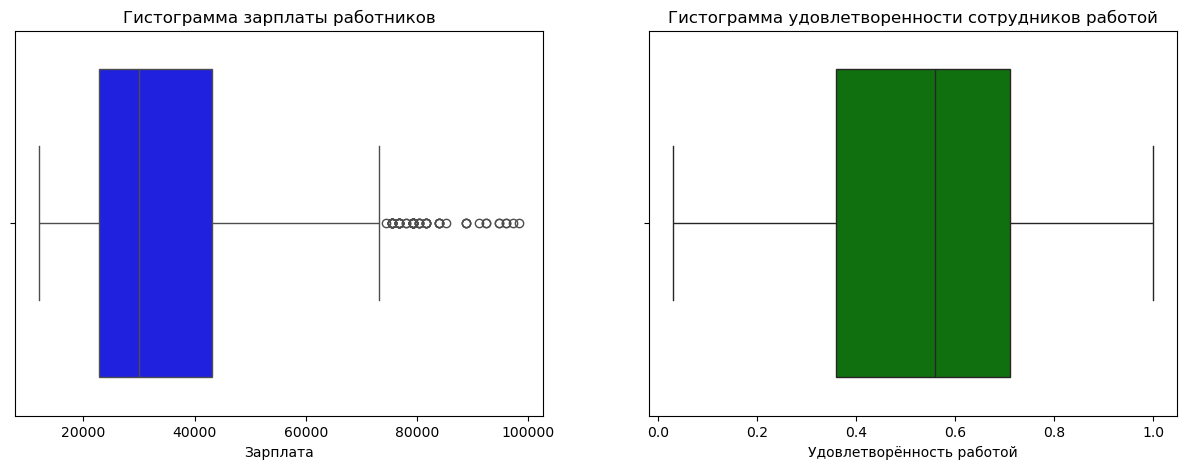

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df_train_job,x='salary',ax=ax[0],color='b')
ax[0].set_xlabel('Зарплата')
ax[0].set_title('Гистограмма зарплаты работников')

sns.boxplot(data=df_train_job,x='job_satisfaction_rate',ax=ax[1],color='g')
ax[1].set_xlabel('Удовлетворённость работой')
ax[1].set_title('Гистограмма удовлетворенности сотрудников работой')
plt.show()

В признике зарплаты работкиков наблюдаются незначительные выбросы. Оставим их без изменений

Количественный признак 'salary' необходимо масштабировать на этапе подготовки данных.

Исследуем категориальные признаки в таблице

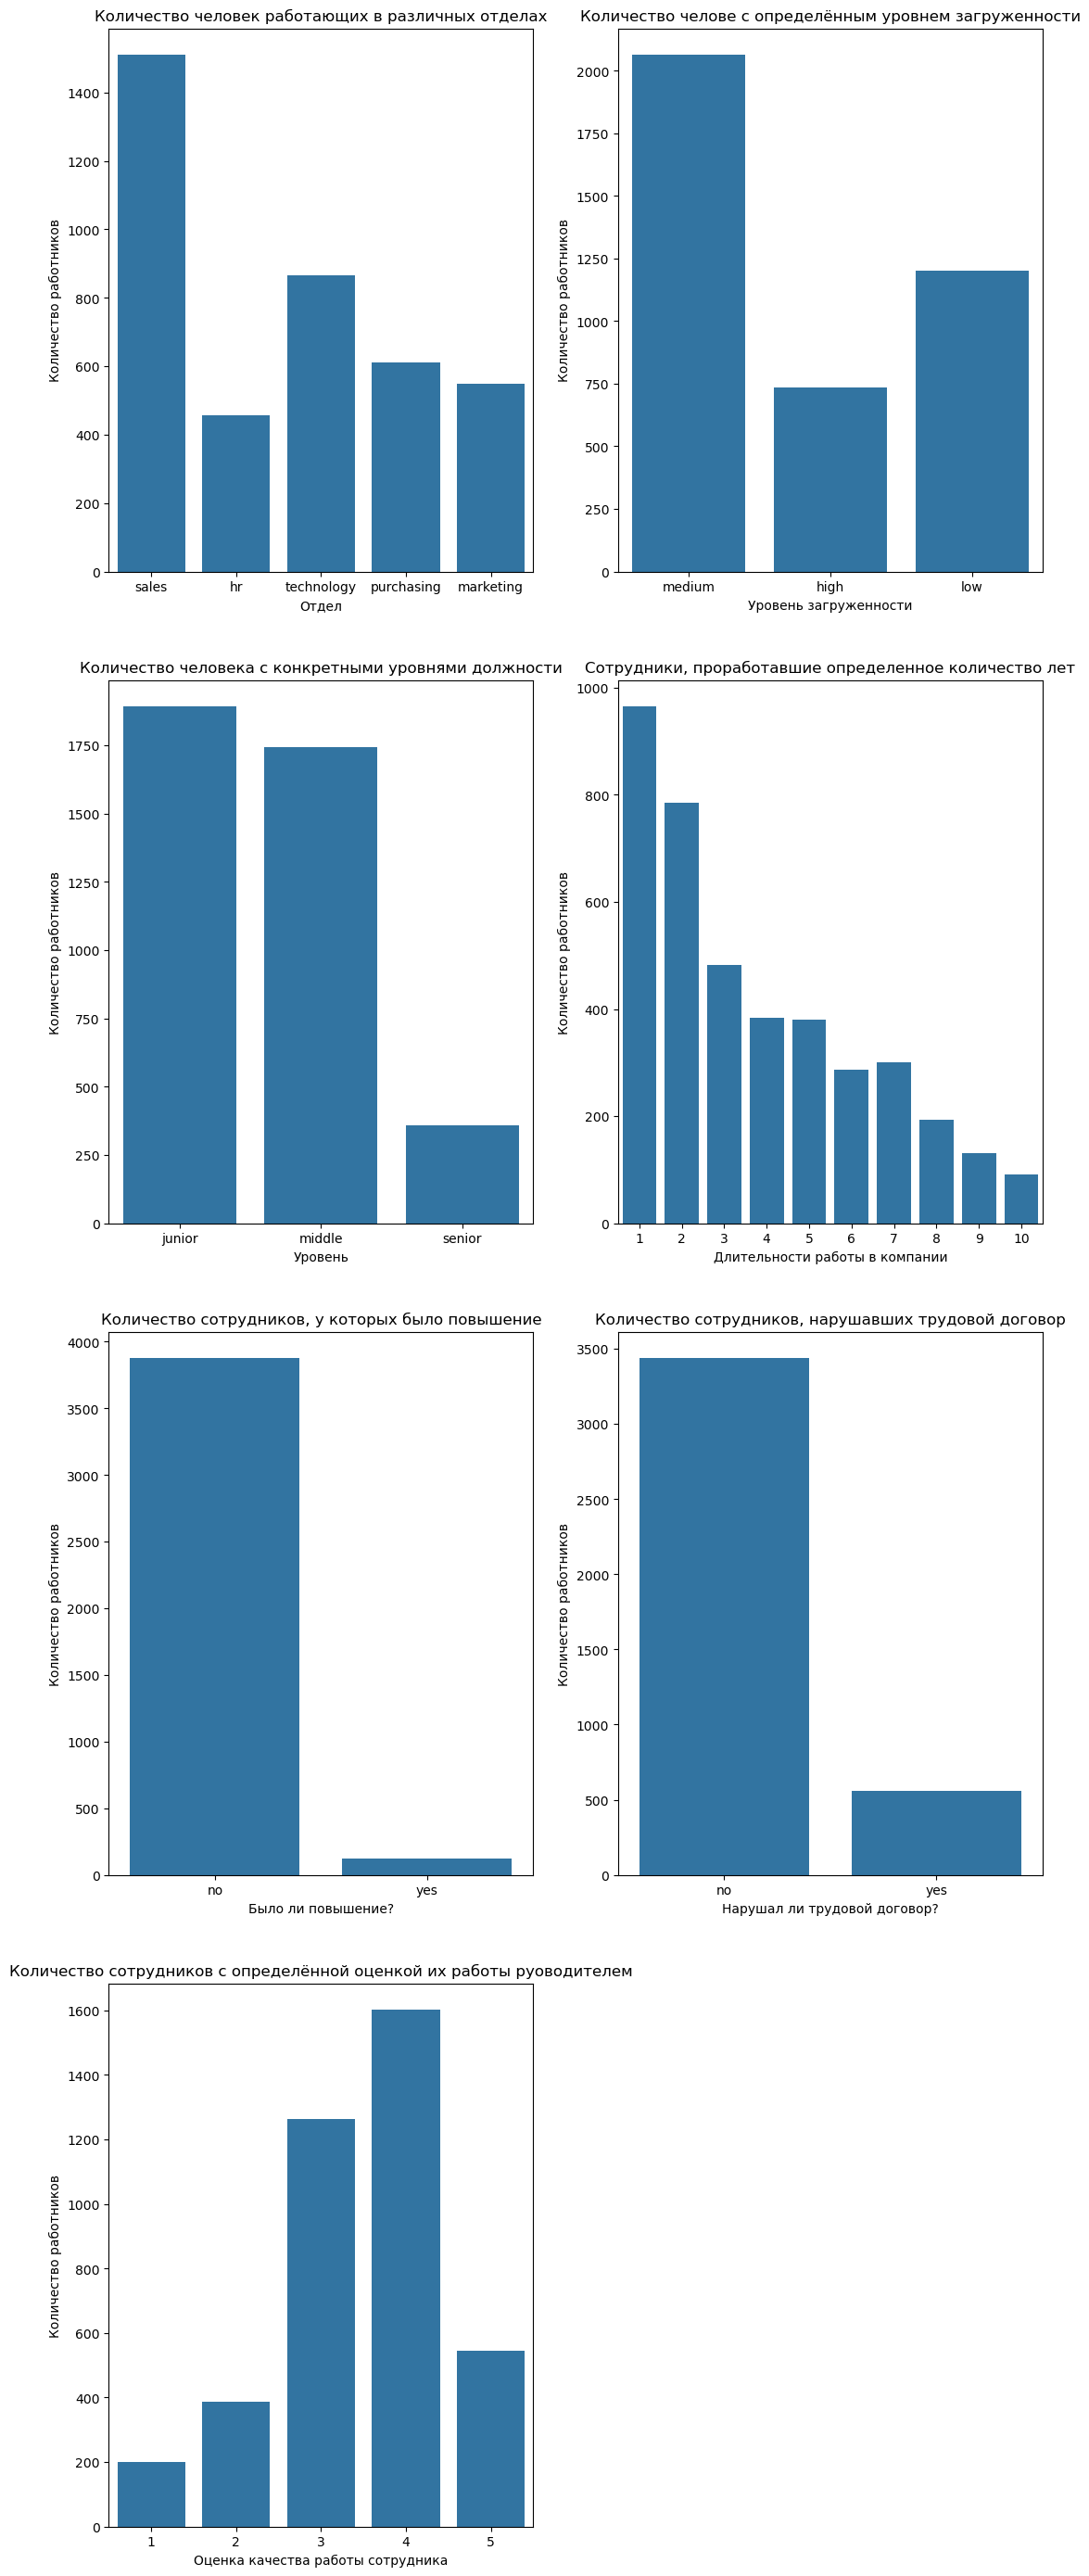

In [104]:
fig, ax = plt.subplots(4, 2, figsize=(13, 35))

sns.countplot(data = df_train_job,x='dept',ax=ax[0,0])
ax[0,0].set_xlabel('Отдел')
ax[0,0].set_ylabel('Количество работников')
ax[0,0].set_title('Количество человек работающих в различных отделах')

sns.countplot(data=df_train_job,x='level',ax=ax[1,0])
ax[1,0].set_xlabel('Уровень')
ax[1,0].set_ylabel('Количество работников')
ax[1,0].set_title('Количество человека с конкретными уровнями должности')

sns.countplot(data=df_train_job,x='workload',ax=ax[0,1])
ax[0,1].set_xlabel('Уровень загруженности')
ax[0,1].set_ylabel('Количество работников')
ax[0,1].set_title('Количество челове с определённым уровнем загруженности')

sns.countplot(data=df_train_job,x='employment_years',ax=ax[1,1])
ax[1,1].set_xlabel('Длительности работы в компании')
ax[1,1].set_ylabel('Количество работников')
ax[1,1].set_title('Cотрудники, проработавшие определенное количество лет')

sns.countplot(data=df_train_job,x='last_year_promo',ax=ax[2,0])
ax[2,0].set_xlabel('Было ли повышение?')
ax[2,0].set_ylabel('Количество работников')
ax[2,0].set_title('Количество сотрудников, у которых было повышение')

sns.countplot(data=df_train_job,x='last_year_violations',ax=ax[2,1])
ax[2,1].set_xlabel('Нарушал ли трудовой договор?')
ax[2,1].set_ylabel('Количество работников')
ax[2,1].set_title('Количество сотрудников, нарушавших трудовой договор')


sns.countplot(data=df_train_job,x='supervisor_evaluation',ax=ax[3,0])
ax[3,0].set_xlabel('Оценка качества работы сотрудника')
ax[3,0].set_ylabel('Количество работников')
ax[3,0].set_title('Количество сотрудников с определённой оценкой их работы руоводителем')

ax[3, 1].set_axis_off()

plt.show()

* Признак "Отдел": Больше всего работников задействовано в отделе продаж. Признак требует кодирования.
* Признак "Уровень загруженности": Больше всего работников со средним уровнем загруженности. Признак требует кодирования.
* Признак "Уровень должности": Больше всего работникво с уровнем должности Джуниор и Миддл. Признак требует кодирования.
* Признак "Количество лет в компании". Убывающее распределение. Больше всего сотрудников работает небольше двух лет.
* Признак "Повышение". Наблюдается серьёзный дисбаланс классов. Признак требует кодирования. 
* Признак "Нарушение трудового договора". Нарушается серьёзный дисбаланс классов. Признак требует кодирования.
* Признак "Оценка качества работы сотрудника". Унимодальное распределение 

#### Исследование тестового датасета

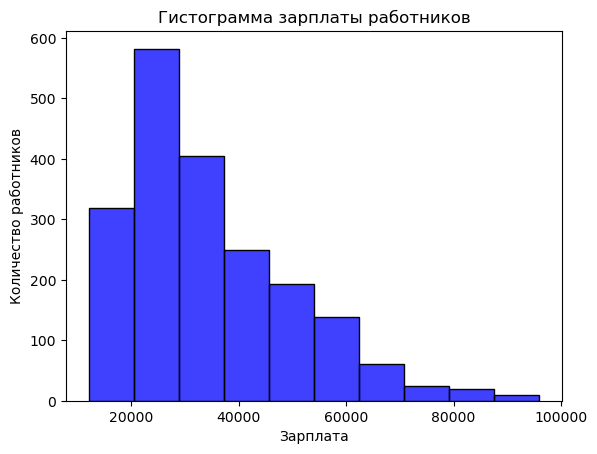

In [105]:
sns.histplot(df_test_features['salary'],color='b',bins=10)
plt.xlabel('Зарплата')
plt.ylabel('Количество работников')
plt.title('Гистограмма зарплаты работников')

plt.show()

Распределение прзнака "Зарплата" близко к распределению из тренировочного датасета.

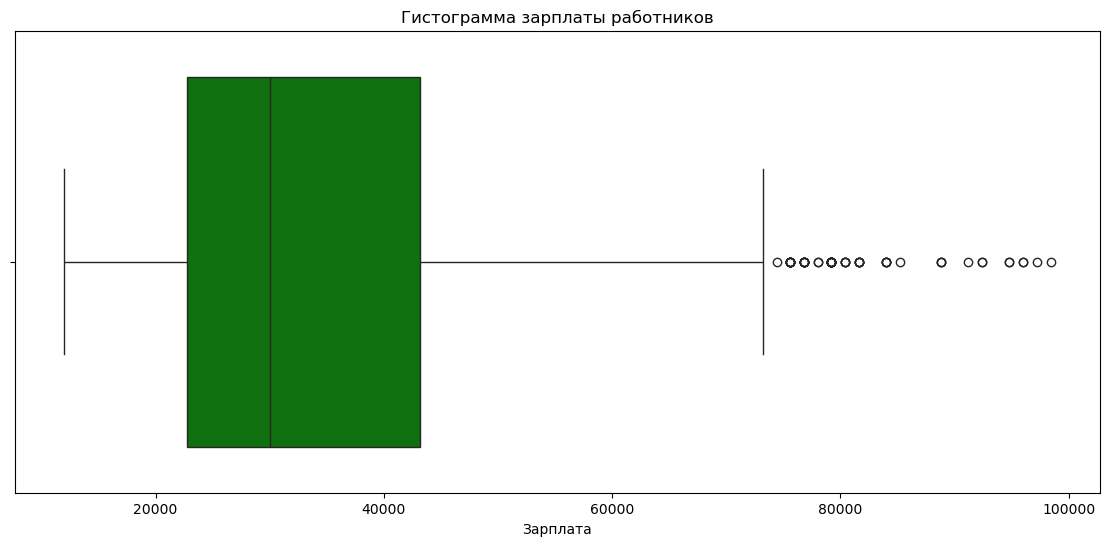

In [106]:
plt.figure(figsize=(14,6))

sns.boxplot(data=df_train_job,x='salary',color='g')
plt.xlabel('Зарплата')
plt.title('Гистограмма зарплаты работников')

plt.show()

В тестовых данных также присутствуют выбросы, что подтверждает правильность решения оставить выбросы в тренировочных данных.

Исследуем категориальные признаки из тестового датасета

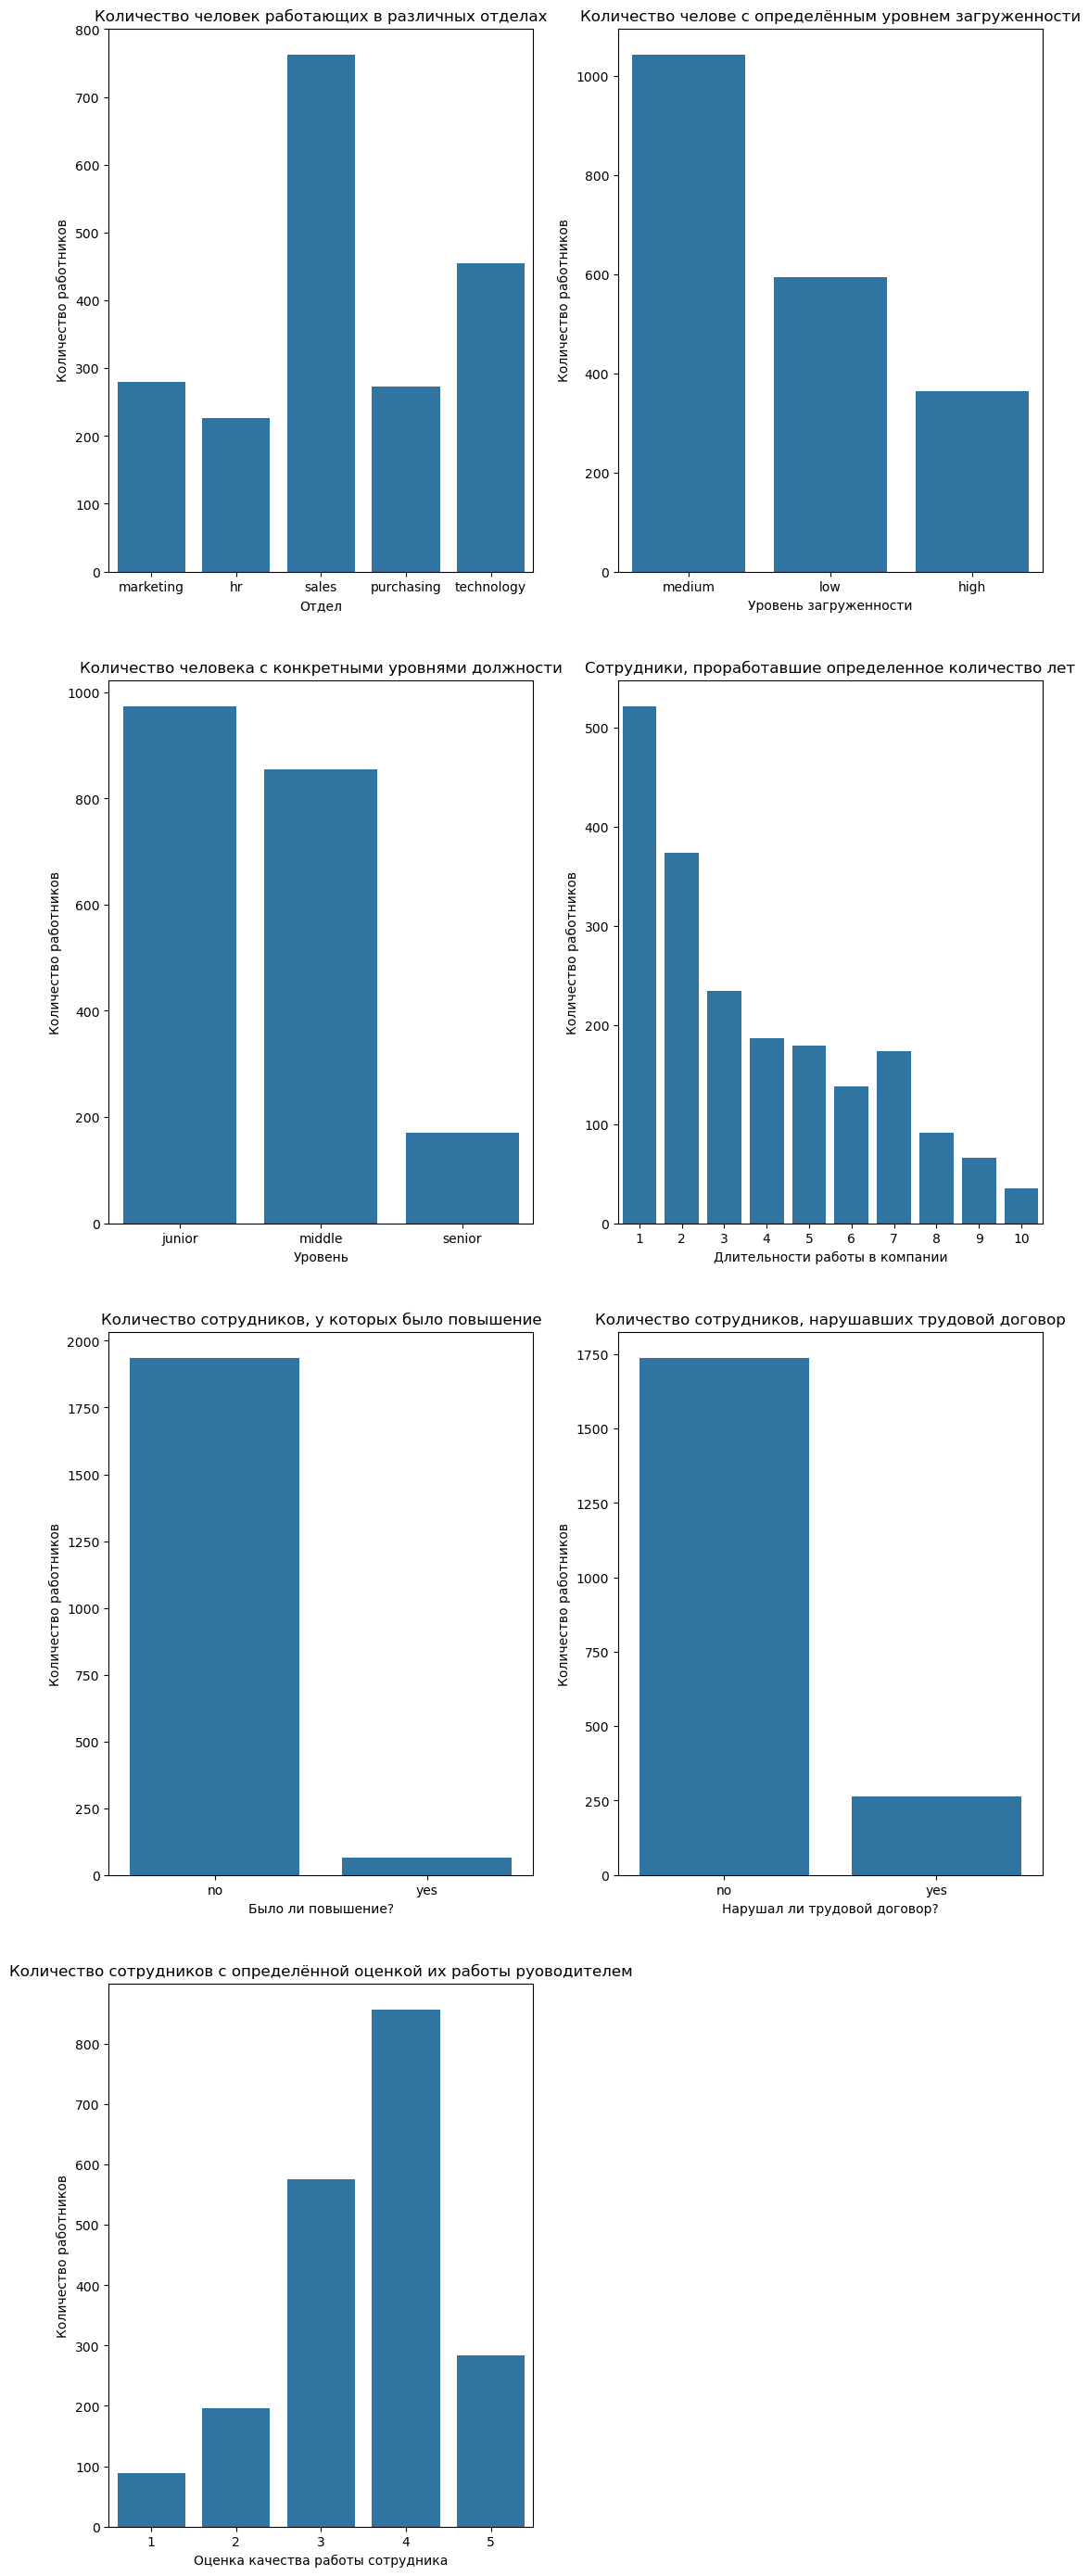

In [107]:
fig, ax = plt.subplots(4, 2, figsize=(13, 35))

sns.countplot(data = df_test_features,x='dept',ax=ax[0,0])
ax[0,0].set_xlabel('Отдел')
ax[0,0].set_ylabel('Количество работников')
ax[0,0].set_title('Количество человек работающих в различных отделах')

sns.countplot(data=df_test_features,x='level',ax=ax[1,0])
ax[1,0].set_xlabel('Уровень')
ax[1,0].set_ylabel('Количество работников')
ax[1,0].set_title('Количество человека с конкретными уровнями должности')

sns.countplot(data=df_test_features,x='workload',ax=ax[0,1])
ax[0,1].set_xlabel('Уровень загруженности')
ax[0,1].set_ylabel('Количество работников')
ax[0,1].set_title('Количество челове с определённым уровнем загруженности')

sns.countplot(data=df_test_features,x='employment_years',ax=ax[1,1])
ax[1,1].set_xlabel('Длительности работы в компании')
ax[1,1].set_ylabel('Количество работников')
ax[1,1].set_title('Cотрудники, проработавшие определенное количество лет')

sns.countplot(data=df_test_features,x='last_year_promo',ax=ax[2,0])
ax[2,0].set_xlabel('Было ли повышение?')
ax[2,0].set_ylabel('Количество работников')
ax[2,0].set_title('Количество сотрудников, у которых было повышение')

sns.countplot(data=df_test_features,x='last_year_violations',ax=ax[2,1])
ax[2,1].set_xlabel('Нарушал ли трудовой договор?')
ax[2,1].set_ylabel('Количество работников')
ax[2,1].set_title('Количество сотрудников, нарушавших трудовой договор')


sns.countplot(data=df_test_features,x='supervisor_evaluation',ax=ax[3,0])
ax[3,0].set_xlabel('Оценка качества работы сотрудника')
ax[3,0].set_ylabel('Количество работников')
ax[3,0].set_title('Количество сотрудников с определённой оценкой их работы руоводителем')

ax[3, 1].set_axis_off()

plt.show()

* Признак "Отдел": Больше всего работников задействовано в отделе продаж. Признак требует кодирования.
* Признак "Уровень загруженности": Больше всего работников со средним уровнем загруженности. Признак требует кодирования.
* Признак "Уровень должности": Больше всего работникво с уровнем должности Джуниор и Миддл. Признак требует кодирования.
* Признак "Количество лет в компании". Убывающее распределение. Больше всего сотрудников работает небольше двух лет.
* Признак "Повышение". Наблюдается серьёзный дисбаланс классов. Признак требует кодирования. 
* Признак "Нарушение трудового договора". Нарушается серьёзный дисбаланс классов. Признак требует кодирования.
* Признак "Оценка качества работы сотрудника". Унимодальное распределение 

Распределения признаков не отличаются от тренировочного датасета

Исследуем распределение целевого признака из тестового датасета

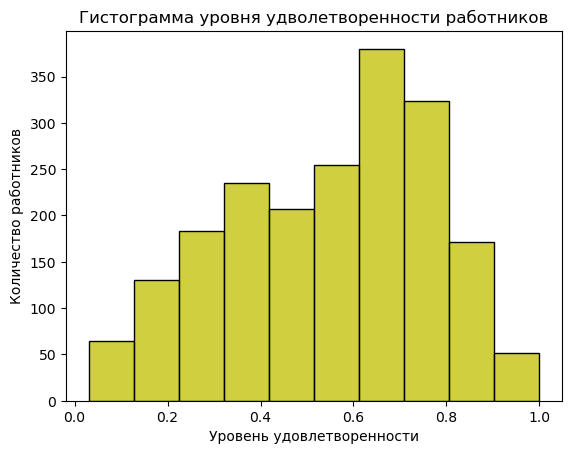

In [108]:
sns.histplot(df_test_target_job['job_satisfaction_rate'],color='y',bins=10)
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Количество работников')
plt.title('Гистограмма уровня удволетворенности работников')

plt.show()

Распеределение целевого признака из тестовго датасета неотличается от распределения из тренировочного датасета.

**Исследовательский анализ данных: Вывод**

* Был проведён графический анализ всех признаков из теренировочного и тестового датасетов.
* Были определены признаки подлежащие кодированию и масштабированию

Признаки для масштабирования

* Зарплата работника
* Уровень удовлетворённости работника

Признаки для кодирования

* Отдел работника
* Уровень загруженности работника
* Уровень должности работника
* Было ли повышение работника
* Нарушал ли работник трудовой договор


### Подготовка данных

#### Корреляционный анализ признаков

Проанализируем связь между признаками с помощью матрицы корреляции.

Создадим список с непрерывными признаками

In [109]:
interval_cols = ['job_satisfaction_rate','salary']

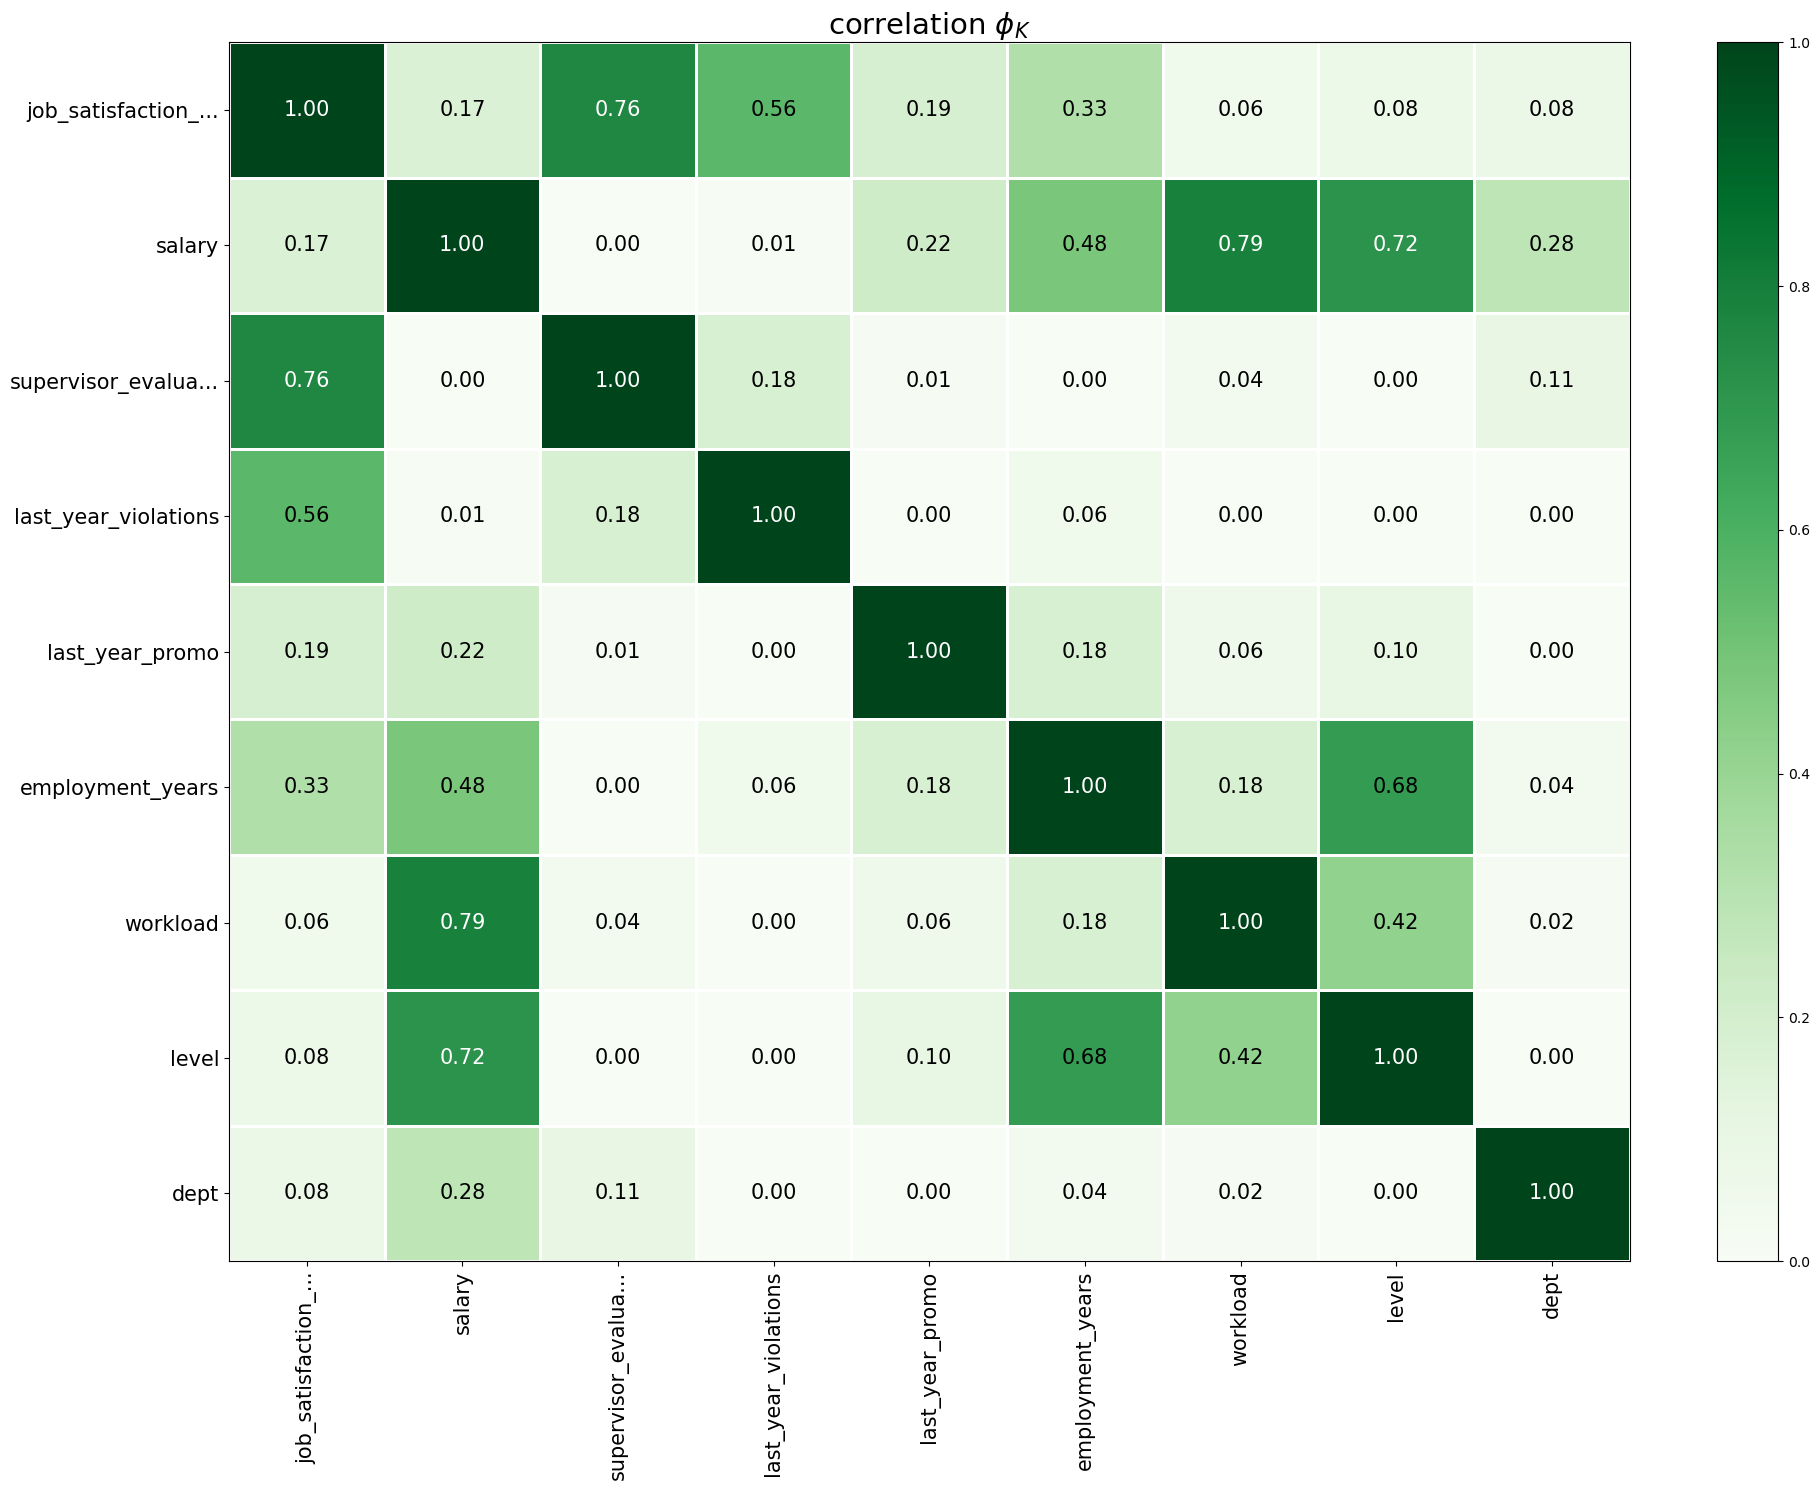

In [110]:
phik_overview = phik_matrix(df_train_job,interval_cols=interval_cols)

plot_correlation_matrix( phik_overview.values, x_labels=phik_overview.columns,y_labels=phik_overview.index,
                        vmin=0, vmax=1, 
                        color_map='Greens',
                        title=r'correlation $\phi_K$',
                        fontsize_factor=1.5, figsize=(20, 15))

* Проведен корреляционный анализ таблицы для моделирования.
* Значительная корреляция наблюдается между целевым признаком и признаком "Оценка качества работы сотрудника". Однако таких значений коэффициента корреляции недостаточно, чтобы говорить о необходимости устранения этих признаков.
* Высокая корреляция наблюдается между двумя входными признаками "Уровень загруженности","Зарплата". Однако значение коэффициента корреляции мало, для того, чтобы можно было говорить о мультиколлинеарности

Проведем корреляционный анализ признаков тестового датасета

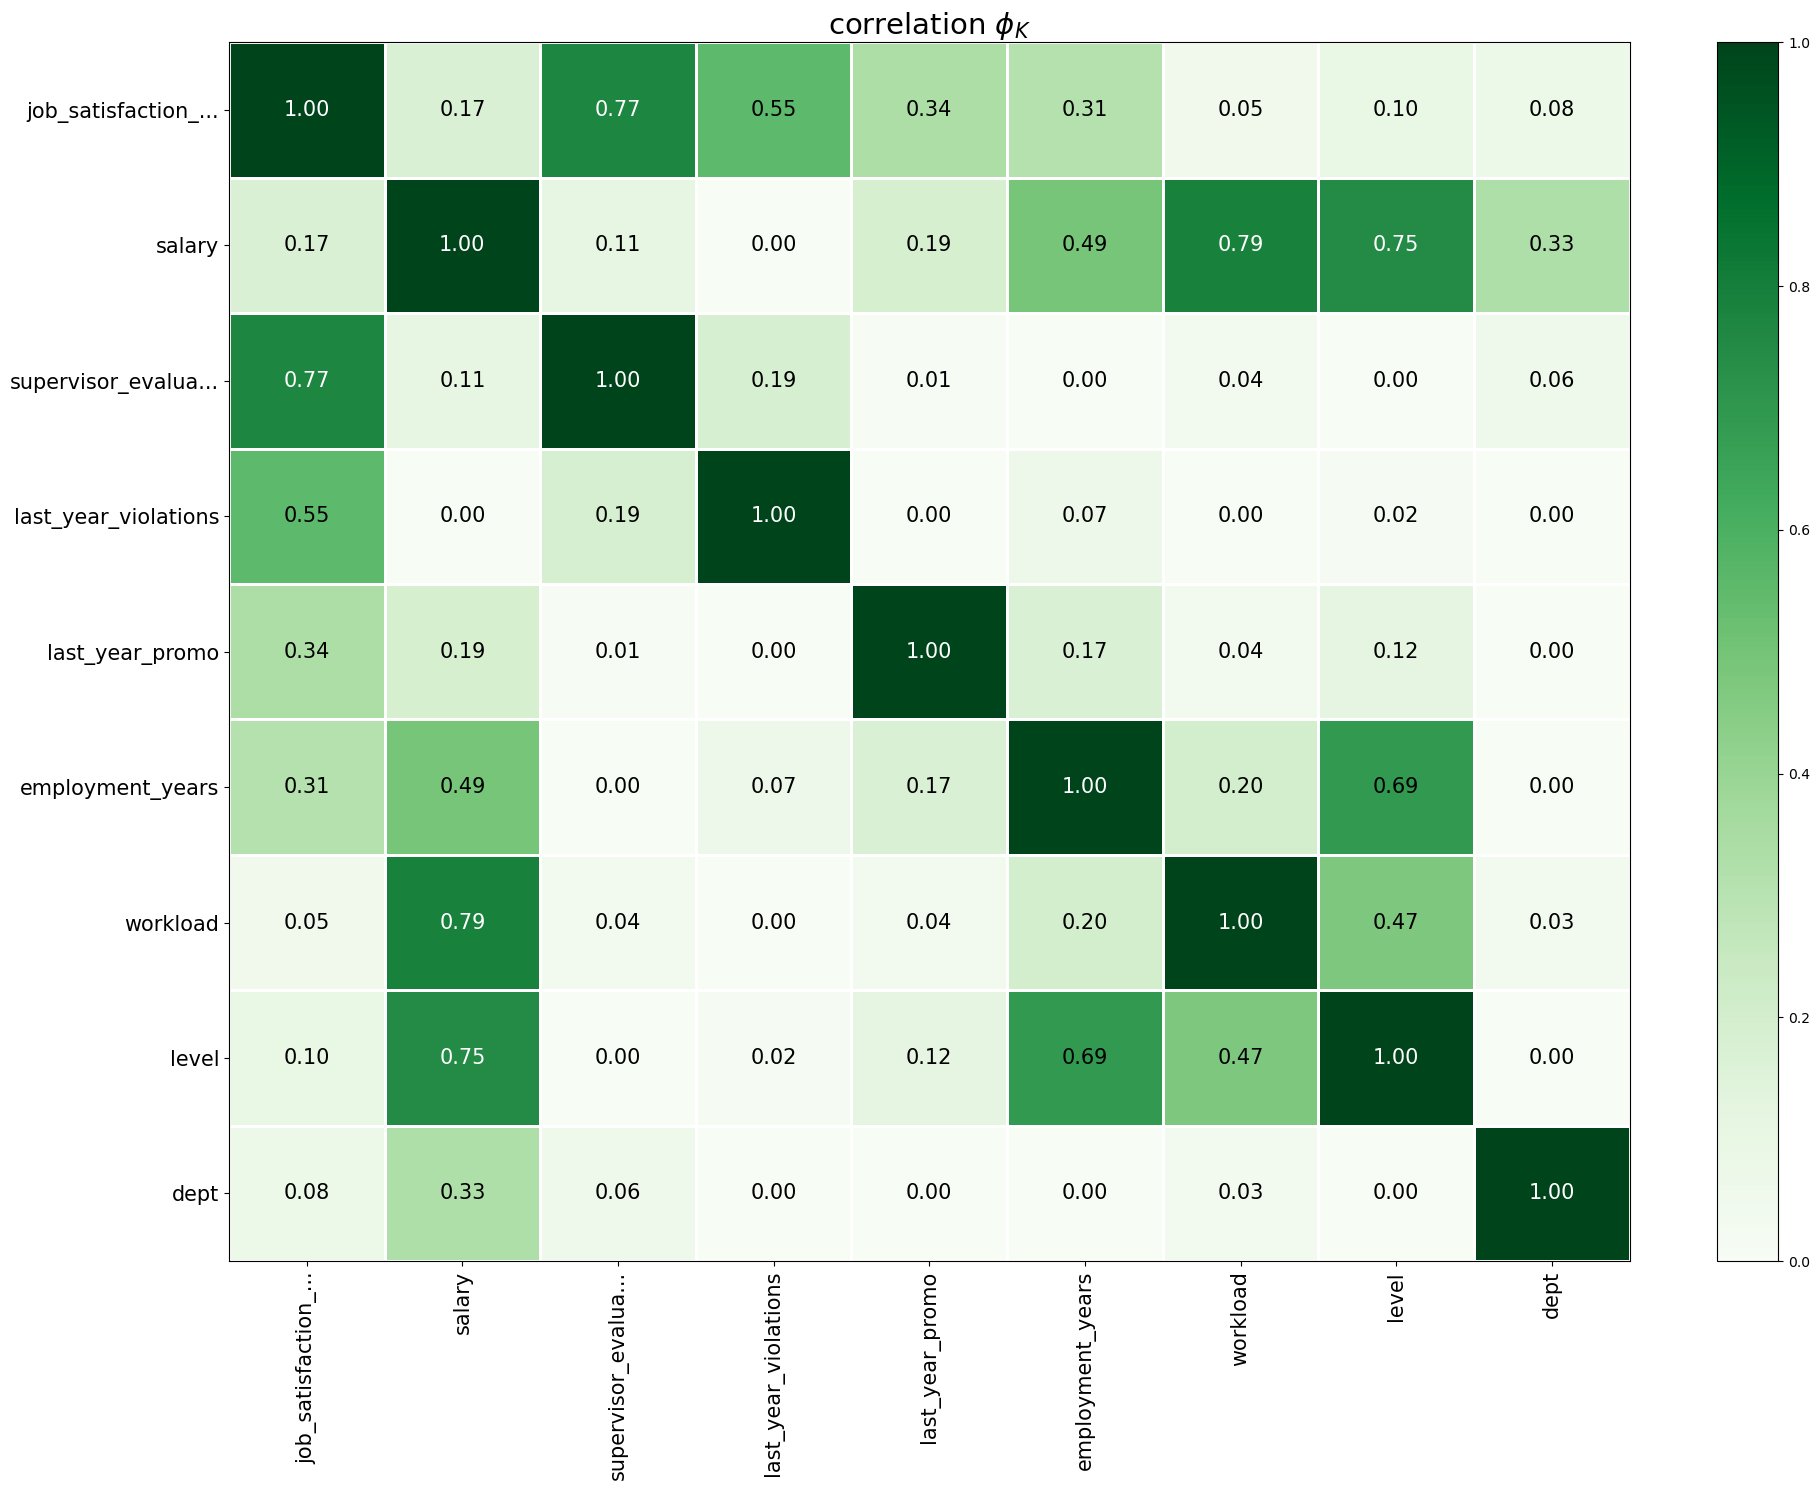

In [111]:
phik_overview = phik_matrix(df_test_features.join(df_test_target_job),interval_cols=interval_cols)

plot_correlation_matrix( phik_overview.values, x_labels=phik_overview.columns,y_labels=phik_overview.index,
                        vmin=0, vmax=1, 
                        color_map='Greens',
                        title=r'correlation $\phi_K$',
                        fontsize_factor=1.5, figsize=(20, 15))

* Проведен корреляционный анализ данных из тестового датасета
* Значительная корреляция наблюдается между целевым признаком и признаком "Оценка качества работы сотрудника". Однако таких значений коэффициента корреляции недостаточно, чтобы говорить о необходимости устранения этих признаков.
* Высокая корреляция наблюдается между двумя входными признаками "Уровень загруженности","Зарплата". Однако значение коэффициента корреляции мало, для того, чтобы можно было говорить о мультиколлинеарности

**Вывод**

В результете проведенного корреляционного анализа не было обнаружено мультиколлинеарности и утечки целевого признака

#### Пайплайн предобработки

Подготовим списки названий столбцов для последующей обработки

In [112]:
num_columns = ['salary']


ohe_columns = ['dept','level','workload']

ord_columns = ['last_year_promo','last_year_violations']

Проверим тренировочный датасет на наличие дубликатов.

In [113]:
print(f'Количество дубликатов в тренировочном датасете: {df_train_job.duplicated().sum()}')

Количество дубликатов в тренировочном датасете: 245


In [114]:
df_train_job = df_train_job.drop_duplicates()

In [115]:
df_train_job.shape

(3755, 9)

Из таблицы были удалены повторяющиеся наблюдения

Разделим данные

In [116]:
RANDOM_STATE = 42

X_train_job = df_train_job.drop(columns=['job_satisfaction_rate'])

In [117]:
y_train_job = df_train_job['job_satisfaction_rate'] 


df_test = df_test_features.join(df_test_target_job,how='outer')
y_test_job =  df_test['job_satisfaction_rate']
X_test_job = df_test.drop(columns=['job_satisfaction_rate'])

Создадим пайплайн предобработки столбцов с OHE кодированием

In [118]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 

Создадим пайплайн предобработки столбцов с Ordinal кодированием

In [119]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Создадим пайплайн, объединяющий шаги предбработки

In [120]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False
) 

**Вывод**

* На данном шаге были подготовлены пайплайны для обработки данных перед обучением

### Обучение моделей

#### Нахождение оптимальной модели

Создадим функцию для вычисления значения метрики SMAPE

In [121]:
def SMAPE_metric(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_pred - y_true) / denominator
    diff[denominator == 0] = 0 
    return np.abs(np.mean(diff)) * 100  

SMAPE = make_scorer(SMAPE_metric, greater_is_better=False) 

Опишем финальный пайплайн включающий шаги по предобработки данных и обучению модели.

In [122]:
pipe_final = Pipeline([ ('preprocessor', data_preprocessor),
                        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))])

Зададим словарь с гиперпараметрами для перебора

In [123]:
param_distributions = [
    {
        'models': [LinearRegression()],
    },
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(2, 20)
    }
]

Будем перебирать параметры с помощью рандомизированного поиска

In [124]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring=SMAPE, 
    random_state=42,
    n_iter=14
)

randomized_search.fit(X_train_job, y_train_job)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('\nМетрика лучшей модели на кросс-валидации:', round(abs(randomized_search.best_score_),2))

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'level',
                                                   'workload']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_bef

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


Лучшей моделью оказалась модель дерева решений для задачи регрессии.

Найдём значение метрики на тестовых данных. Для этого подготовим данные для прогноза

In [125]:
X_train_new_job = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train_job)
X_test_new_job = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test_job)
X_train_new_job = pd.DataFrame(X_train_new_job,columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
X_test_new_job = pd.DataFrame(X_test_new_job,columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())

model_job = randomized_search.best_estimator_.named_steps['models']
model_job.fit(X_train_new_job,y_train_job)

,criterion,'squared_error'
,splitter,'best'
,max_depth,18
,min_samples_split,8
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


Предскажем целевую переменную на тестовых данных и оценим метрику SMAPE

In [126]:
y_pred_job = model_job.predict(X_test_new_job)
print ('\nМетрика лучшей модели на тестовой выборке:', round(abs(SMAPE_metric(y_test_job,y_pred_job)),2))


Метрика лучшей модели на тестовой выборке: 13.55


Полученное значение метрики удовлетворяет требованиям задания

**Выводы**

* С помощью метода рандомизированного поиска была найдена модель дающее наилучшее значение метрика SMAPE
* Наилучшей моделью оказалась модель дерева решений для задачи регрессии
* Лучшее значение метрики SMAPE на кросс-валидации составило 15.25
* Лучшее значение метрики SMAPE на тестовой выборке составило 13.55

**Проверка на адекватность**

Создадим модель для константных предсказаний среднего значения тренировочной выборки

In [127]:
model_dum_reg = DummyRegressor(strategy='mean')

Обучим модель на тренировочных данных

In [128]:
model_dum_reg.fit(X_train_new_job,y_train_job)

,strategy,'mean'
,constant,None
,quantile,None


Предкажем значения на тестовой выборке

In [129]:
y_pred = model_dum_reg.predict(X_test_new_job)

Получим значение метрики SMAPE на тестовой выборке

In [130]:
print(f'Значение метрики SMAPE на тестовой выборке {round(SMAPE_metric(y_test_job,y_pred),2)}')

Значение метрики SMAPE на тестовой выборке 38.26


Значение метрики полученное при константных предсказаниях намного больше чем то, что получено с помощью найденной модели. 

#### Исследование важности признаков модели

Выясним какие признаки больше всего делают вклад в предсказание. Построим SHAP графики

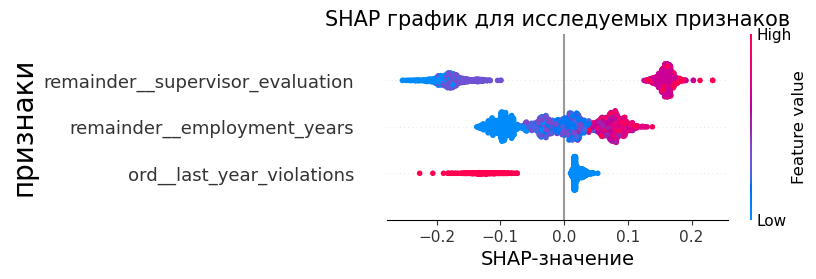

In [131]:
fig, ax = plt.gcf(), plt.gca()
explainer = shap.TreeExplainer(model_job)
shap_values = explainer(X_test_new_job)

shap.summary_plot(shap_values, X_test_new_job,show=False,max_display=3)

ax.set_title('SHAP график для исследуемых признаков', fontdict={"size":15})
ax.set_xlabel("SHAP-значение", fontsize=14)
ax.set_ylabel("признаки", fontsize=20)
plt.show()

Анализ признаков показывает, что призники наиболее влияющие на удовлетворённость сотрудника работой:

1) Оценка сотрудника руководителем. Высокие значения соответсвую высокой уровнем удовлетворенности

2) Количество лет, которые сотрудник проработал в компании. Высокие значения соответсвуют высоким уровнем удовлетворенности

3) Зарплата. Высокие значения соотвествуют высокой удовлетворённости сотрудника

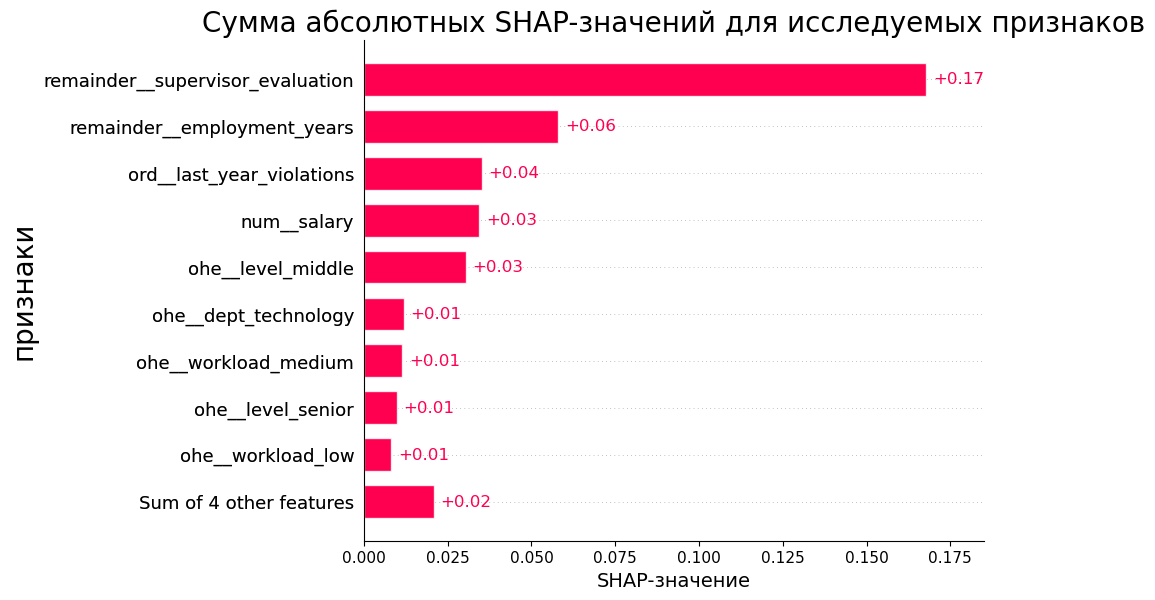

In [132]:
fig, ax = plt.gcf(), plt.gca()

shap.plots.bar(shap_values,show=False)
ax.set_title('Сумма абсолютных SHAP-значений для исследуемых признаков', fontdict={"size":20})
ax.set_xlabel("SHAP-значение", fontsize=14)
ax.set_ylabel("признаки", fontsize=20)
plt.show()

**Вывод**

Анализ признаков показывает, что призники наиболее влияющие на удовлетворённость сотрудника работой:

1) Оценка сотрудника руководителем. Высокие значения соответсвую высокой уровнем удовлетворенности

2) Количество лет, которые сотрудник проработал в компании. Высокие значения соответсвуют высоким уровнем удовлетворенности

3) Зарплата. Высокие значения соотвествуют высокой удовлетворённости сотрудника

### Выводы по первой задаче и рекомендации бизнесу

В результате проведенной работы были получены следующие результаты

1. **Загрузка данных.** Все данные были загружены. Произведено первичное ознакомление с данными.
2. **Предобработка данных.** Таблицы были проанализированы на наличие пропусков, дубликатов и неявных дубликатов. Были устранены проблемы в данных. 
3. **Исследовательский анализ данных.** 

* Был проведён графический анализ всех признаков из теренировочного и тестового датасетов.
* Были определены признаки подлежащие кодированию и масштабированию

4. **Подготовка данных** 

* Проведен корреляционный анализ таблицы для моделирования
* Мультиколлинеарности и утечки целевого признака не обнаружено
* На данном шаге были подготовлены пайплайны для обработки данных перед обучением

5. **Обучение моделей**

* С помощью метода рандомизированного поиска была найдена модель дающее наилучшее значение метрика SMAPE
* Наилучшей моделью оказалась модель дерева решений для задачи регрессии
* Лучшее значение метрики SMAPE на кросс-валидации составило 15.25
* Лучшее значение метрики SMAPE на тестовой выборке составило 13.55


Анализ признаков показывает, что призники наиболее влияющие на удовлетворённость сотрудника работой:

1) Оценка сотрудника руководителем. Высокие значения соответсвую высокой уровнем удовлетворенности

2) Количество лет, которые сотрудник проработал в компании. Высокие значения соответсвуют высоким уровнем удовлетворенности

3) Зарплата. Высокие значения соотвествуют высокой удовлетворённости сотрудника

**Рекомендации бизнесу**

Для увеличения уровня удовлетворённости сотрудников работой

**Оценка сотрудника руководителем**

* Подчёркивайте достижения сотрудников и давайте рекомендации для дальнейшего роста. Это помогает сотрудникам чувствовать, что их усилия замечаются и оцениваются по достоинству.

**Количество лет работы в компании**

* Разработайте программы, которые будут поощрять долгосрочную работу в компании. Например, бонусы за определённый стаж работы

**Зарплата** 

* Регулярно проверяйте рыночные ставки и пересматривайте зарплаты сотрудников в зависимости от их вклада, опыта и рынка. Даже небольшие корректировки могут значительно повысить удовлетворённость.

## Предсказание увольнения сотрудника 

### Загрузка данных

Загрузим тренировочную выборку для второй задачи

In [133]:
df_train_quit = pd.read_csv('data/train_quit.csv')

In [134]:
df_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Выведем общую информацию о датасете для второй задачи

In [135]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Загрузим данные с целевым признаком тестовой выборки для второй задачи

In [136]:
df_test_target_quit = pd.read_csv('data/test_target_quit.csv')

In [137]:
df_test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Выведем общую информацию о загруженных данных

In [138]:
df_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Данные для решения второй задачи были успешно загружены

### Предобработка данных

#### Предобработка данных тренировочного датасета для второй задачи

**Анализ таблицы на наличие пропусков**

In [139]:
df_train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

В данных отсутствуют пропуски

**Анализ таблицы на наличие дубликатов**

In [140]:
df_train_quit.duplicated().sum()

0

**Анализ таблицы на наличие неявных дубликатов**

In [141]:
columns = ['dept','level','workload','last_year_promo','last_year_violations','quit']

for i in columns:
    print(f'Уникальные значения в колонке {i}: {df_train_quit[i].unique()}')

Уникальные значения в колонке dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения в колонке level: ['middle' 'junior' 'sinior']
Уникальные значения в колонке workload: ['high' 'medium' 'low']
Уникальные значения в колонке last_year_promo: ['no' 'yes']
Уникальные значения в колонке last_year_violations: ['no' 'yes']
Уникальные значения в колонке quit: ['no' 'yes']


В данных отсутствуют неявные дубликаты

Исправим грамматическую ошибку в данных

In [142]:
df_train_quit['level'] = df_train_quit['level'].replace('sinior','senior')

**Изменение индексов таблицы**

Изменим индексы таблицы на индексы каждого работника

In [143]:
df_train_quit = df_train_quit.set_index('id')

In [144]:
df_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


#### Предобработка данных целевого признака тестового датасета для второй задачи

**Анализ таблицы на наличие пропусков**

In [145]:
df_test_target_quit.isna().sum()

id      0
quit    0
dtype: int64

В таблице отсутсвуют пропуски

**Анализ таблицы на наличие дубликатов**

In [146]:
df_test_target_quit.duplicated().sum()

0

В таблице отсутствуют дубликаты

**Изменение индексов таблицы**

Изменим индексы таблицы на индексы работкиков

In [147]:
df_test_target_quit = df_test_target_quit.set_index('id')

In [148]:
df_test_target_quit.head()

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


**Вывод**

Таблицы были проанализированы на наличие пропусков, дубликатов и неявных дубликатов. Были устранены проблемы в данных. 

### Исследовательский анализ данных

#### Исследовательский анализ тренировочного датасета

Исследуем количественные признаки в таблице

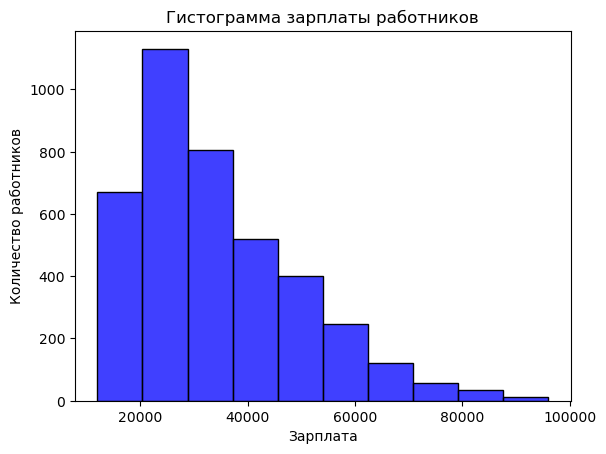

In [149]:
sns.histplot(df_train_quit['salary'],color='b',bins=10)
plt.xlabel('Зарплата')
plt.ylabel('Количество работников')
plt.title('Гистограмма зарплаты работников')

plt.show()

Гистограмма заработной платы работников представляет собой унимодальное распределение смещённое влево. Проверим выбросы с помощью диаграммы разброса.

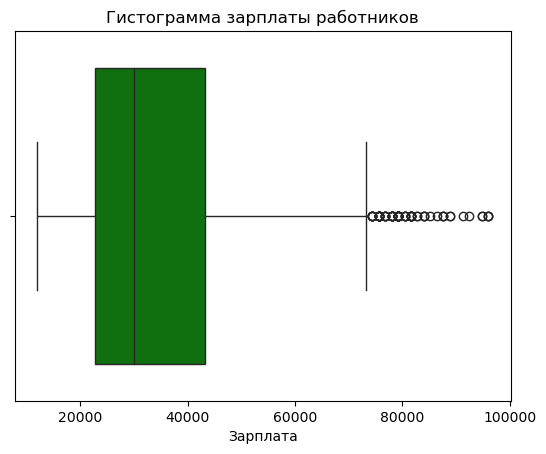

In [150]:
sns.boxplot(data=df_train_quit,x='salary',color='g')
plt.xlabel('Зарплата')
plt.title('Гистограмма зарплаты работников')

plt.show()

На диаграмме разброса видны выбросы. Не будем избавляться от них в силу их незначительности.

Количественный признак "salary" необходимо мастабировать на этапе подготовки данных

Исследуем категориальные признаки в таблице

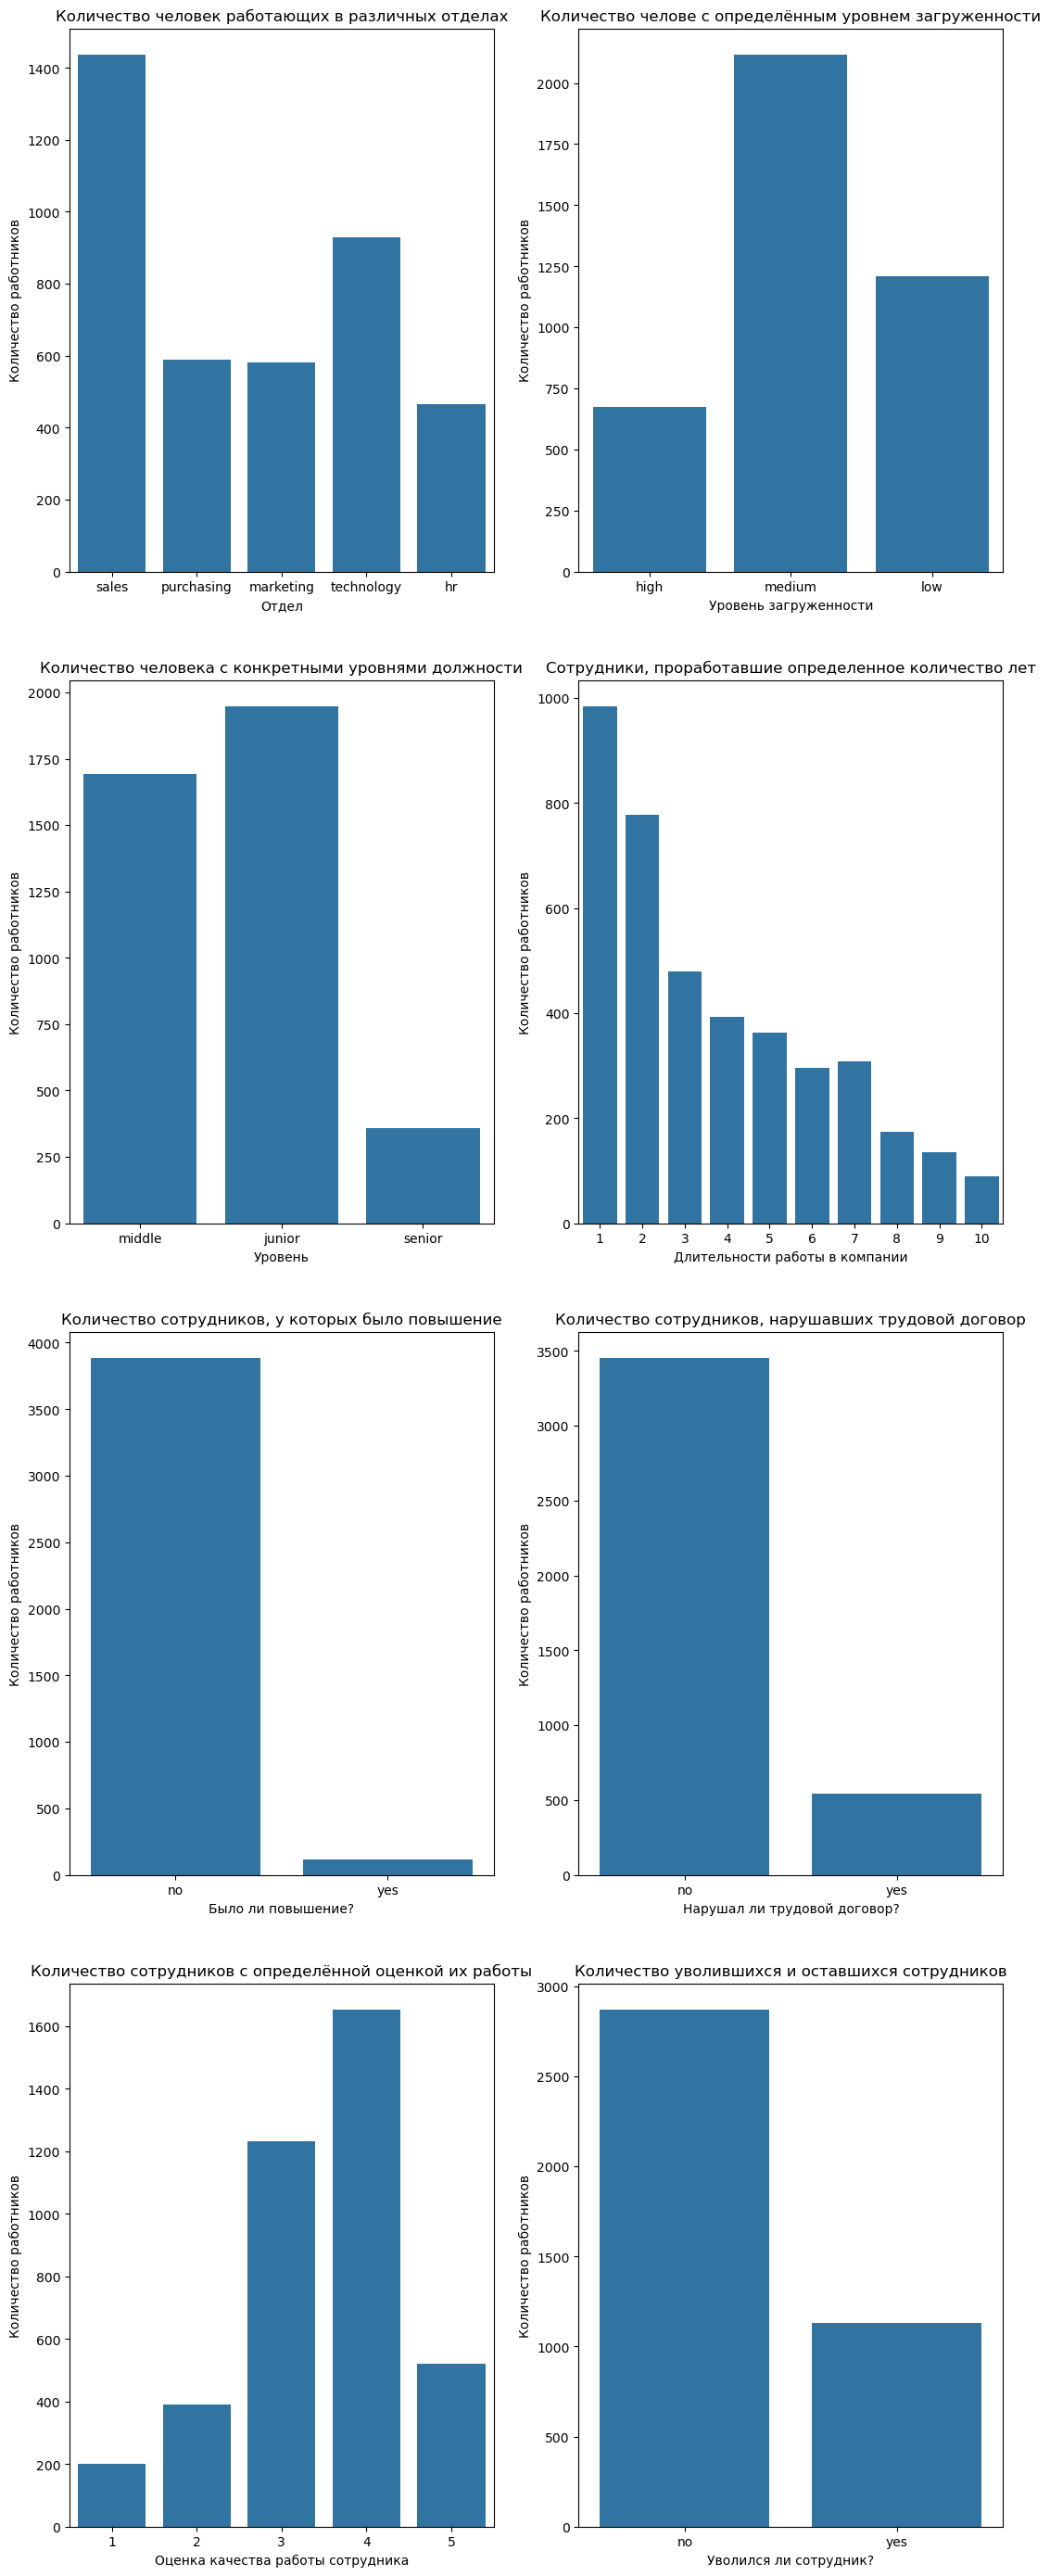

In [151]:
fig, ax = plt.subplots(4, 2, figsize=(13, 35))

sns.countplot(data = df_train_quit,x='dept',ax=ax[0,0])
ax[0,0].set_xlabel('Отдел')
ax[0,0].set_ylabel('Количество работников')
ax[0,0].set_title('Количество человек работающих в различных отделах')

sns.countplot(data=df_train_quit,x='level',ax=ax[1,0])
ax[1,0].set_xlabel('Уровень')
ax[1,0].set_ylabel('Количество работников')
ax[1,0].set_title('Количество человека с конкретными уровнями должности')

sns.countplot(data=df_train_quit,x='workload',ax=ax[0,1])
ax[0,1].set_xlabel('Уровень загруженности')
ax[0,1].set_ylabel('Количество работников')
ax[0,1].set_title('Количество челове с определённым уровнем загруженности')

sns.countplot(data=df_train_quit,x='employment_years',ax=ax[1,1])
ax[1,1].set_xlabel('Длительности работы в компании')
ax[1,1].set_ylabel('Количество работников')
ax[1,1].set_title('Cотрудники, проработавшие определенное количество лет')

sns.countplot(data=df_train_quit,x='last_year_promo',ax=ax[2,0])
ax[2,0].set_xlabel('Было ли повышение?')
ax[2,0].set_ylabel('Количество работников')
ax[2,0].set_title('Количество сотрудников, у которых было повышение')

sns.countplot(data=df_train_quit,x='last_year_violations',ax=ax[2,1])
ax[2,1].set_xlabel('Нарушал ли трудовой договор?')
ax[2,1].set_ylabel('Количество работников')
ax[2,1].set_title('Количество сотрудников, нарушавших трудовой договор')


sns.countplot(data=df_train_quit,x='supervisor_evaluation',ax=ax[3,0])
ax[3,0].set_xlabel('Оценка качества работы сотрудника')
ax[3,0].set_ylabel('Количество работников')
ax[3,0].set_title('Количество сотрудников с определённой оценкой их работы')

sns.countplot(data=df_train_quit,x='quit',ax=ax[3,1])
ax[3,1].set_xlabel('Уволился ли сотрудник?')
ax[3,1].set_ylabel('Количество работников')
ax[3,1].set_title('Количество уволившихся и оставшихся сотрудников')

plt.show()

* Признак "Отдел": Больше всего работников задействовано в отделе продаж. Признак требует кодирования.
* Признак "Уровень загруженности": Больше всего работников со средним уровнем загруженности. Признак требует кодирования.
* Признак "Уровень должности": Больше всего работникво с уровнем должности Джуниор и Миддл. Признак требует кодирования.
* Признак "Количество лет в компании". Убывающее распределение. Больше всего сотрудников работает небольше двух лет.
* Признак "Повышение". Наблюдается серьёзный дисбаланс классов. Признак требует кодирования. 
* Признак "Нарушение трудового договора". Нарушается серьёзный дисбаланс классов. Признак требует кодирования.
* Признак "Оценка качества работы сотрудника". Унимодальное распределение 
* Признак "Уволнение сотрудника" - целевой бинарный признак. Наблюдается дисбаланс классов. Требует кодирования.

#### Исследовательский анализ тестового датасета

Датасет df_test_features был исследован в задаче №1. Исследуем целевой признак в тестовой выборке

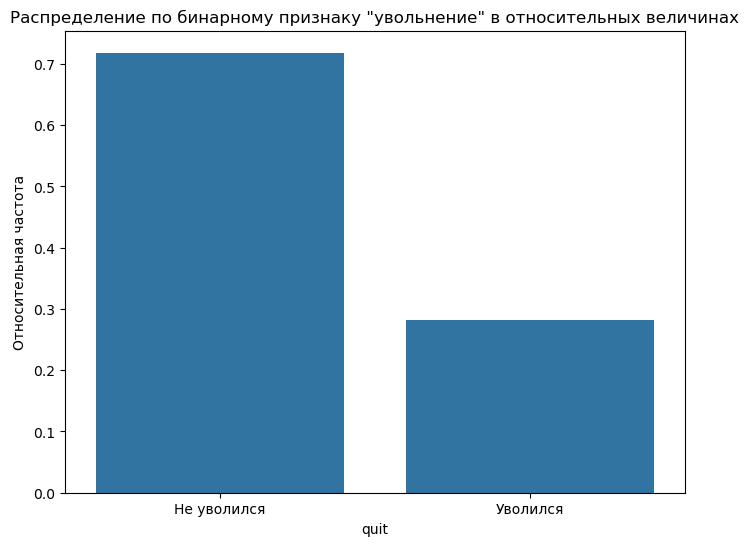

In [152]:
relative_counts = df_train_quit['quit'].value_counts(normalize=True)


plt.figure(figsize=(8, 6))
sns.barplot(x=relative_counts.index, y=relative_counts.values)

plt.title('Распределение по бинарному признаку "увольнение" в относительных величинах')
plt.ylabel('Относительная частота')
plt.xticks([0, 1], ['Не уволился', 'Уволился'])  

plt.show()

По графику видно, что в данных целевого признака тестового датасета также наблюдается дисбаланс классов.

#### Составление портрета уволившегося сотрудника

**Увольнения сотрудников по отделам**

Проанализируем количество увольнений сотрудников из различных отделов

In [153]:
dept_dict = {'sales':'Отдел продаж','purchasing': "Отдел закупок",
             'marketing':'Отдел маркетинга','technology':"Отдел технологический",'hr':'Отдел HR'}

data_to_plot = []

for i in df_train_quit['dept'].unique():
    df = df_train_quit.query('quit == "yes"')
    print(dept_dict[i])
    probability = round((df["dept"]).value_counts(normalize=True).loc[i], 2)
    print(f'Доля увольнений от общего числа: {probability}','\n')
    data_to_plot.append({'dept': dept_dict[i].split()[1], 'quit_probability': probability})


Отдел продаж
Доля увольнений от общего числа: 0.36 

Отдел закупок
Доля увольнений от общего числа: 0.15 

Отдел маркетинга
Доля увольнений от общего числа: 0.14 

Отдел технологический
Доля увольнений от общего числа: 0.24 

Отдел HR
Доля увольнений от общего числа: 0.1 



C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\3608575489.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dept', y='quit_probability', data=plot_df, palette='viridis')


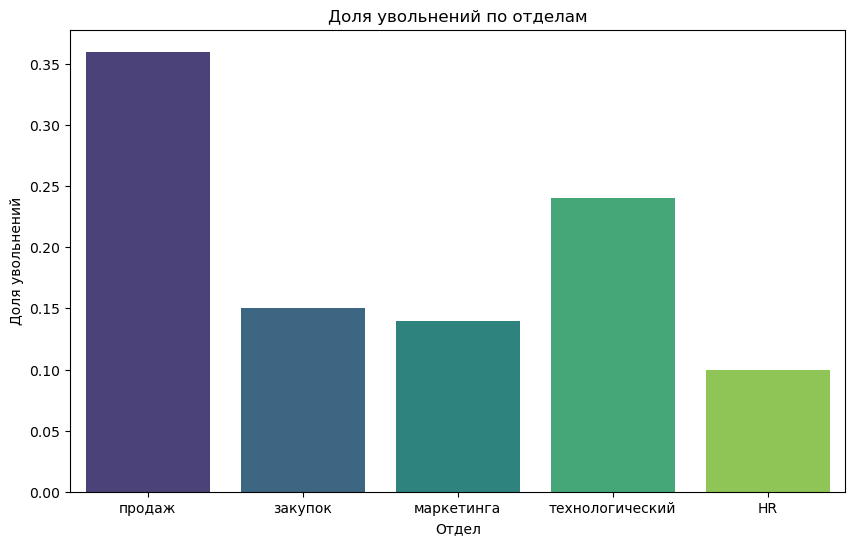

In [154]:
plot_df = pd.DataFrame(data_to_plot)
plt.figure(figsize=(10, 6))

sns.barplot(x='dept', y='quit_probability', data=plot_df, palette='viridis')


plt.title('Доля увольнений по отделам')
plt.xlabel('Отдел')
plt.ylabel('Доля увольнений')


plt.show()

Приведенный график показывает, что наибольшая доля увольнений наблюдается в отделе продаж.

**Увольнения сотрудников в зависимости от уровня загруженности**

In [155]:
df_train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [156]:
load_dict = {'high':'Высокая нагруженность','medium': "Средняя нагруженность",
             'low':'Низкая нагруженность'}

data_to_plot = []

for i in df_train_quit['workload'].unique():
    df = df_train_quit.query('quit == "yes"')
    print(load_dict[i])
    probability = round(df["workload"].value_counts(normalize=True).loc[i], 2)
    print(f'Доля увольнений: {probability}','\n')
    data_to_plot.append({'workload': load_dict[i].split()[0], 'quit_probability': probability})
    

Высокая нагруженность
Доля увольнений: 0.11 

Средняя нагруженность
Доля увольнений: 0.43 

Низкая нагруженность
Доля увольнений: 0.46 



Построим график по этим данным

C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\3742271517.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='workload', y='quit_probability', data=plot_df, palette='viridis')


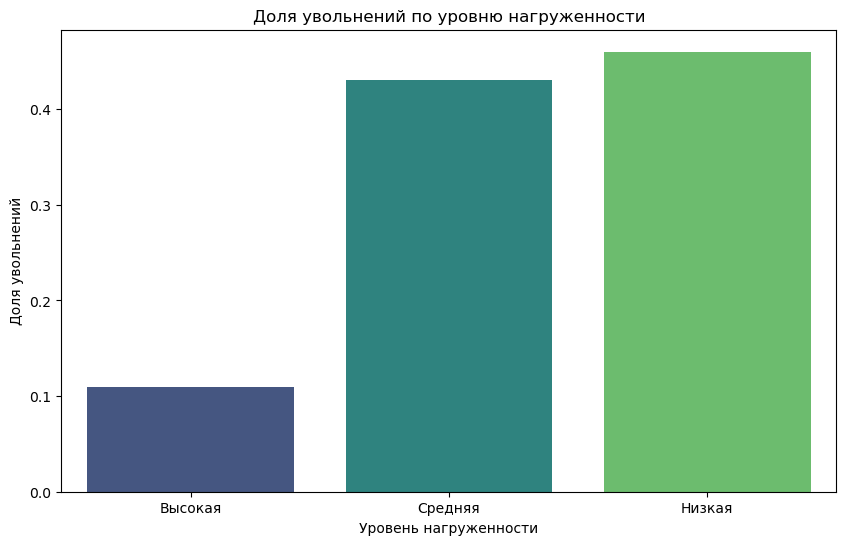

In [157]:
plot_df = pd.DataFrame(data_to_plot)
plt.figure(figsize=(10, 6))

sns.barplot(x='workload', y='quit_probability', data=plot_df, palette='viridis')


plt.title('Доля увольнений по уровню нагруженности')
plt.xlabel('Уровень нагруженности')
plt.ylabel('Доля увольнений')

plt.show()

График показывает, что наибольшая вероятность увольнения у работников имеющих низкий уровень нагруженности

**Увольнения сотрудников в зависимости от уровня занимаемой должности**

In [158]:
level_dict = {'junior':'Джуниор','middle': "Мидл",
             'senior':'Сеньор'}

data_to_plot = []

for i in df_train_quit['level'].unique():
    df = df_train_quit.query('quit == "yes"')
    print(level_dict[i])
    probability = round(df["level"].value_counts(normalize=True).loc[i], 2)
    print(f'Доля увольнений от общего числа: {probability}','\n')
    data_to_plot.append({'level': level_dict[i], 'quit_probability': probability})

Мидл
Доля увольнений от общего числа: 0.1 

Джуниор
Доля увольнений от общего числа: 0.89 

Сеньор
Доля увольнений от общего числа: 0.02 



C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\2817508436.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='level', y='quit_probability', data=plot_df, palette='viridis')


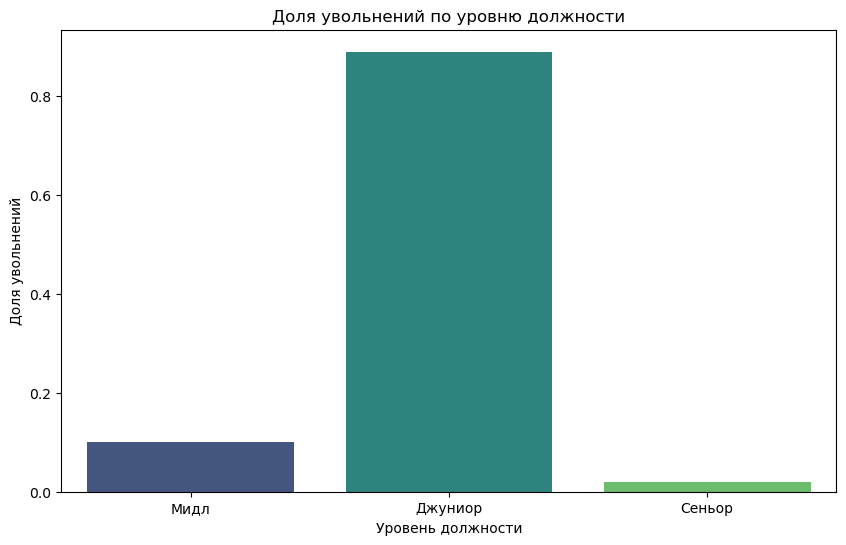

In [159]:
plot_df = pd.DataFrame(data_to_plot)
plt.figure(figsize=(10, 6))

sns.barplot(x='level', y='quit_probability', data=plot_df, palette='viridis')


plt.title('Доля увольнений по уровню должности')
plt.xlabel('Уровень должности')
plt.ylabel('Доля увольнений')

plt.show()

График показывает, что наибольшая доля всех увольнений приходится на работников уровня Джуниор

**Увольнения сотрудников в зависимости от уровня заработной платы**

In [160]:
df_mean_salary = df_train_quit.pivot_table(index='quit',values='salary',aggfunc='mean')
df_median_salary = df_train_quit.pivot_table(index='quit',values='salary',aggfunc='median')

print(f'Средняя зарплата сотрудника уволившегося сотрудника {int(df_mean_salary.loc["yes"])}')
print(f'Средняя зарплата сотрудника оставшегося сотрудника {int(df_mean_salary.loc["no"])}','\n')
print(f'Медианная зарплата сотрудника уволившегося сотрудника {int(df_median_salary.loc["yes"])}')
print(f'Медианная зарплата сотрудника оставшегося сотрудника {int(df_median_salary.loc["no"])}')

Средняя зарплата сотрудника уволившегося сотрудника 23885
Средняя зарплата сотрудника оставшегося сотрудника 37702 

Медианная зарплата сотрудника уволившегося сотрудника 22800
Медианная зарплата сотрудника оставшегося сотрудника 34800


C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\2199312501.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'Средняя зарплата сотрудника уволившегося сотрудника {int(df_mean_salary.loc["yes"])}')
C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\2199312501.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'Средняя зарплата сотрудника оставшегося сотрудника {int(df_mean_salary.loc["no"])}','\n')
C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\2199312501.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'Медианная зарплата сотрудника уволившегося сотрудника {int(df_median_salary.loc["yes"])}')
C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\2199312501.py:7: FutureWarning: Callin

Визуализиуем на графиках

In [161]:
data_to_plot = []
data_to_plot.append({'quit':'Да','mean_salary':int(df_mean_salary.loc["yes"])})
data_to_plot.append({'quit':'Нет','mean_salary':int(df_mean_salary.loc["no"])})
plot_df = pd.DataFrame(data_to_plot)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\2783190912.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  data_to_plot.append({'quit':'Да','mean_salary':int(df_mean_salary.loc["yes"])})
C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\2783190912.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  data_to_plot.append({'quit':'Нет','mean_salary':int(df_mean_salary.loc["no"])})


C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\762893649.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='quit', y='mean_salary', data=plot_df, palette='viridis')


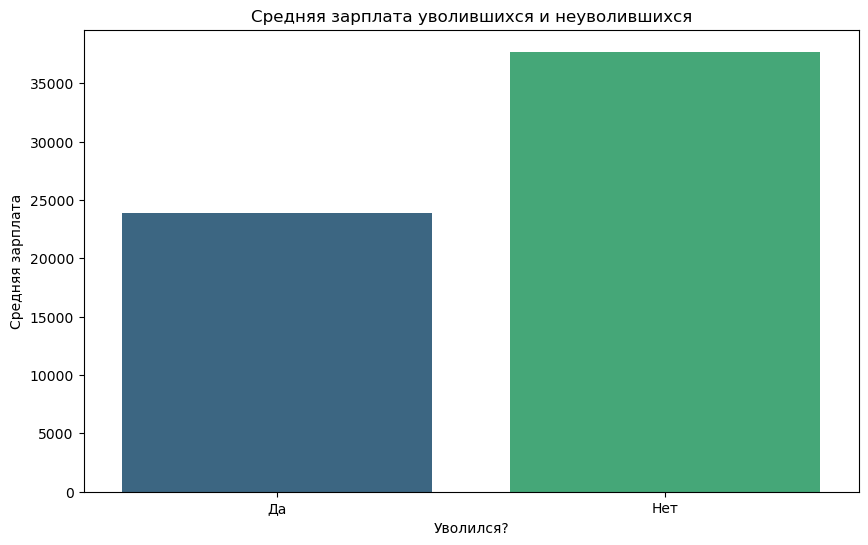

In [162]:
plt.figure(figsize=(10, 6))

sns.barplot(x='quit', y='mean_salary', data=plot_df, palette='viridis')

plt.title('Средняя зарплата уволившихся и неуволившихся')
plt.xlabel('Уволился?')
plt.ylabel('Средняя зарплата')

plt.show()

График показывает, что уровень зарплаты среди уволившихся сотрудников значительно меньше чем среди оставшихся

In [163]:
year_dict = {1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'10'}

data_to_plot = []

for i in df_train_quit['employment_years'].unique():
    df = df_train_quit.query('quit == "yes"')
    print(year_dict[i])
    probability = round(df["employment_years"].value_counts(normalize=True).loc[i], 2)
    print(f'Доля увольнений от общего числа: {probability}','\n')
    data_to_plot.append({'employment_years': year_dict[i], 'quit_probability': probability})

2
Доля увольнений от общего числа: 0.26 

5
Доля увольнений от общего числа: 0.02 

1
Доля увольнений от общего числа: 0.53 

8
Доля увольнений от общего числа: 0.0 

4
Доля увольнений от общего числа: 0.02 

7
Доля увольнений от общего числа: 0.01 

3
Доля увольнений от общего числа: 0.14 

9
Доля увольнений от общего числа: 0.0 

6
Доля увольнений от общего числа: 0.01 

10
Доля увольнений от общего числа: 0.0 



C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\3214733058.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='employment_years', y='quit_probability', data=plot_df, palette='viridis')


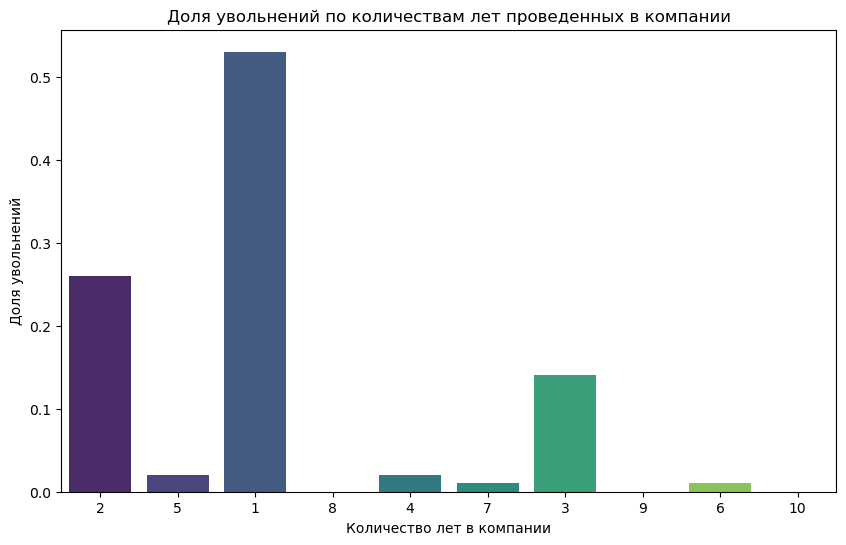

In [164]:
plot_df = pd.DataFrame(data_to_plot)
plt.figure(figsize=(10, 6))

sns.barplot(x='employment_years', y='quit_probability', data=plot_df, palette='viridis')


plt.title('Доля увольнений по количествам лет проведенных в компании')
plt.xlabel('Количество лет в компании')
plt.ylabel('Доля увольнений')

plt.show()

Наибольшая доля увольнений наблюдается в первый год работы

In [165]:
promo_dict = {'yes':'Было повышение','no':'Не было повышения'}

data_to_plot = []

for i in df_train_quit['last_year_promo'].unique():
    df = df_train_quit.query('quit == "yes"')
    print(promo_dict[i])
    probability = round(df["last_year_promo"].value_counts(normalize=True).loc[i], 2)
    print(f'Доля увольнений от общего числа: {probability}','\n')
    data_to_plot.append({'last_year_promo': promo_dict[i], 'quit_probability': probability})

Не было повышения
Доля увольнений от общего числа: 1.0 

Было повышение
Доля увольнений от общего числа: 0.0 



C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\279921047.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='last_year_promo', y='quit_probability', data=plot_df, palette='viridis')


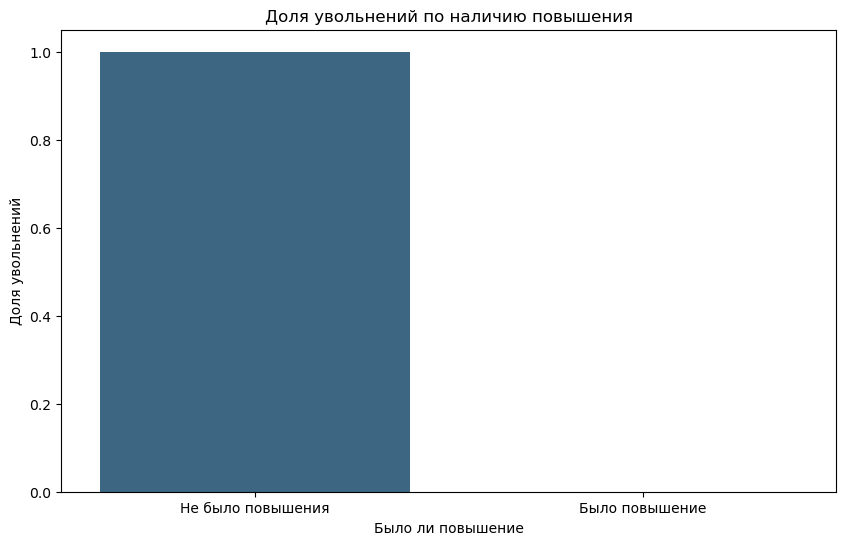

In [166]:
plot_df = pd.DataFrame(data_to_plot)
plt.figure(figsize=(10, 6))

sns.barplot(x='last_year_promo', y='quit_probability', data=plot_df, palette='viridis')


plt.title('Доля увольнений по наличию повышения')
plt.xlabel('Было ли повышение')
plt.ylabel('Доля увольнений')

plt.show()

Распределение показывает, что среди уволившихся работников нет тех, кто был бы повышен.

In [167]:
vio_dict = {'yes':'Нарушал договор','no':'Не нарушал договор'}

data_to_plot = []

for i in df_train_quit['last_year_violations'].unique():
    df = df_train_quit.query('quit == "yes"')
    print(vio_dict[i])
    probability = round(df["last_year_violations"].value_counts(normalize=True).loc[i], 2)
    print(f'Доля увольнений от общего числа: {probability}','\n')
    data_to_plot.append({'last_year_violations': vio_dict[i], 'quit_probability': probability})

Не нарушал договор
Доля увольнений от общего числа: 0.8 

Нарушал договор
Доля увольнений от общего числа: 0.2 



C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\3120458569.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='last_year_violations', y='quit_probability', data=plot_df, palette='viridis')


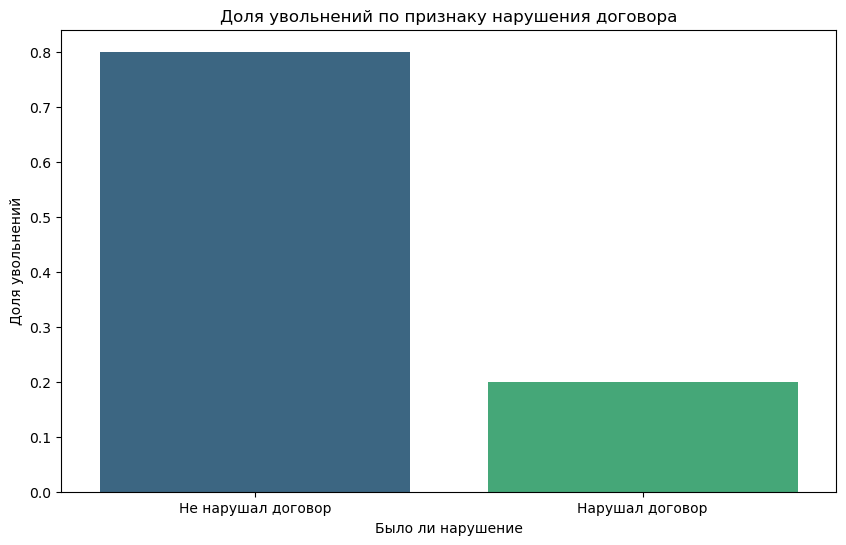

In [168]:
plot_df = pd.DataFrame(data_to_plot)
plt.figure(figsize=(10, 6))

sns.barplot(x='last_year_violations', y='quit_probability', data=plot_df, palette='viridis')


plt.title('Доля увольнений по признаку нарушения договора')
plt.xlabel('Было ли нарушение')
plt.ylabel('Доля увольнений')

plt.show()

График показывает, что среди тех, кто нарушал договор большое количество уволившихся сотрудников. Распределение этого признака значительно отличается от распределение этого признака среди всех работников

In [169]:
year_dict = {1:'1',2:'2',3:'3',4:'4',5:'5'}

data_to_plot = []

for i in df_train_quit['supervisor_evaluation'].unique():
    df = df_train_quit.query('quit == "yes"')
    print(year_dict[i])
    probability = round(df["supervisor_evaluation"].value_counts(normalize=True).loc[i], 2)
    print(f'Доля увольнений от общего числа: {probability}','\n')
    data_to_plot.append({'supervisor_evaluation': year_dict[i], 'quit_probability': probability})

4
Доля увольнений от общего числа: 0.25 

1
Доля увольнений от общего числа: 0.08 

3
Доля увольнений от общего числа: 0.46 

5
Доля увольнений от общего числа: 0.05 

2
Доля увольнений от общего числа: 0.15 



C:\Users\Admin\AppData\Local\Temp\ipykernel_9512\3952839644.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='supervisor_evaluation', y='quit_probability', data=plot_df, palette='viridis')


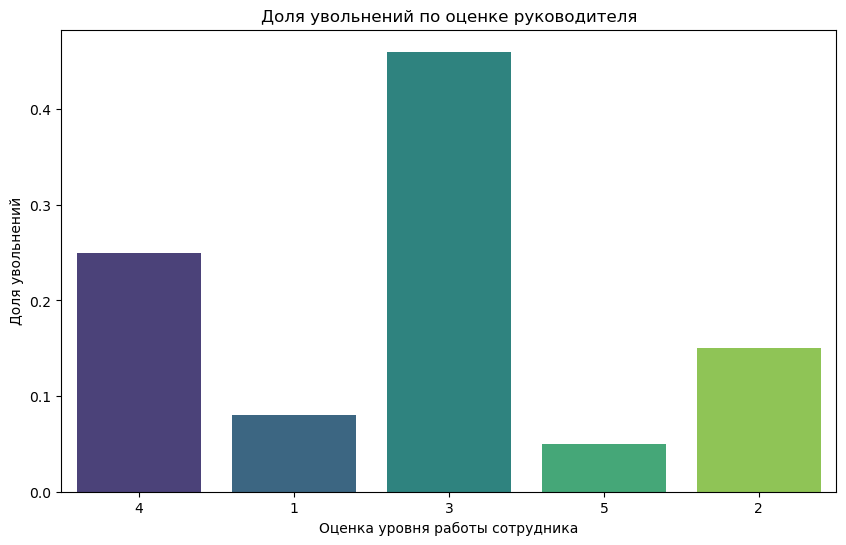

In [170]:
plot_df = pd.DataFrame(data_to_plot)
plt.figure(figsize=(10, 6))

sns.barplot(x='supervisor_evaluation', y='quit_probability', data=plot_df, palette='viridis')


plt.title('Доля увольнений по оценке руководителя')
plt.xlabel('Оценка уровня работы сотрудника')
plt.ylabel('Доля увольнений')

plt.show()

Среди уволившихся работников наибольшая доля тех, кого руководитель оценивает на оценку "3"

**Вывод**


В результате исследования был составлен портрет сотрудника, имеющего высокую вероятность увольнения:

* Низкий уровень нагруженности
* Должность: Джуниор
* Низкий уровень зарплаты
* Нарушал трудовой договор
* Первый год работы
* Низкая оценка руководителем


Наибольшая доля увольнений наблюдается в отделе продаж.

#### Проверка связи удовлетворённости работой и увольнением сотрудника

Проверим связь уровня удовлетворённости работы сотрудника и увольнением.

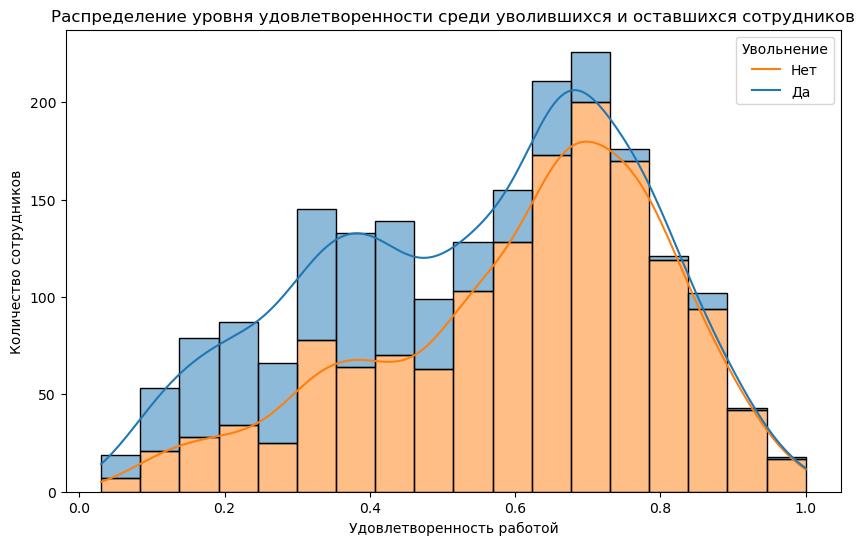

In [171]:
df = df_test_target_quit.join(df_test_target_job,how='inner')
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="job_satisfaction_rate", hue="quit", multiple="stack", kde=True)
plt.title('Распределение уровня удовлетворенности среди уволившихся и оставшихся сотрудников')
plt.xlabel('Удовлетворенность работой')
plt.ylabel('Количество сотрудников')
plt.legend(title="Увольнение", labels=["Нет", "Да"])
plt.show()

Как можно заметить на графике при низком уровне удовлетворённости работой количество увольнений значиетльно превышает количество оставшихся работников. По данным этого графика можно сделать вывод о том, что уровень удовлетворённости влияет на количество увольнений.

Сформулируем статистические гипотезы для проверки

**Нулевая гипотеза:**

Средние двух совокупностей равны между собой.

**Альтернативаня гипотеза:**

Средние двух совокупностей неравны между собой.

Для проверки гипотез будем использовать ttest для двух выборок

Разделим данные на две выборки

In [172]:
df_yes = df.query('quit == "yes"')['job_satisfaction_rate']
df_no = df.query('quit == "no"')['job_satisfaction_rate']

Проверим гипотезу

In [173]:
alpha = 0.01
result = st.ttest_ind(df_yes,df_no) 

print(f"Полученное p-значение: {result.pvalue}")
if alpha < result.pvalue:
    print(f'p-значение больше уровня значимости')
else:
    print(f"p-значение меньше уровня значимости")

Полученное p-значение: 1.2311220665173681e-104
p-значение меньше уровня значимости


Отвергаем нулевую гипотезу и принимаем альтернативую.

Статистически доказано, что средние двух генеральных совокупностей различаются.

Построим нормированные гистограммы по выборкам

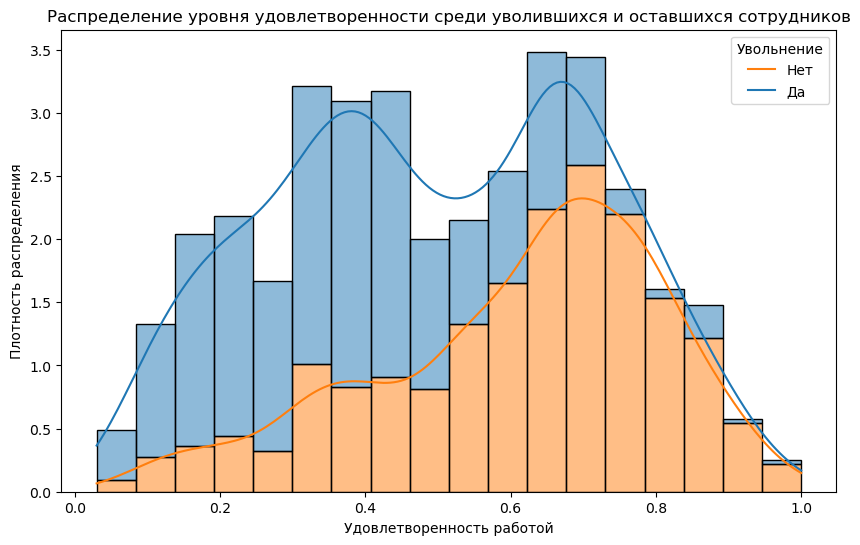

In [174]:
df = df_test_target_quit.join(df_test_target_job, how='inner')
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="job_satisfaction_rate", hue="quit", multiple="stack", kde=True, stat='density', common_norm=False)
plt.title('Распределение уровня удовлетворенности среди уволившихся и оставшихся сотрудников')
plt.xlabel('Удовлетворенность работой')
plt.ylabel('Плотность распределения')
plt.legend(title="Увольнение", labels=["Нет", "Да"])
plt.show()

Как можно заметить на графике при низком уровне удовлетворённости работой количество увольнений значиетльно превышает количество оставшихся работников. По данным этого графика можно сделать вывод о том, что уровень удовлетворённости влияет на количество увольнений.

**Исследовательский анализ данных: Вывод**

* Было выяснено, что уровень удовлетворённости влияет на количество увольнений.
* Был проведён графический анализ всех признаков из теренировочного и тестового датасетов.
* Были определены признаки подлежащие кодированию и масштабированию
* Был составлен портрет сотрудника, имеющего высокую вероятность увольнения:

    * Низкий уровень нагруженности
    * Должность: Джуниор
    * Низкий уровень зарплаты

Наибольшая вероятность увольнения наблюдается в технологическом отделе.


Признаки для масштабирования

* Зарплата работника
* Уровень удовлетворённости работника

Признаки для кодирования

* Отдел работника
* Уровень загруженности работника
* Уровень должности работника
* Было ли повышение работника
* Нарушал ли работник трудовой договор




### Добавление признака

Разделим признаки тренеровочного датасета на входные и целевой

In [175]:
print(f'Всего дубликатов в данных: {df_train_quit.duplicated().sum()}')

Всего дубликатов в данных: 1413


Удалим дубликаты в тренировочных данных

In [176]:
X_train_quit = df_train_quit.drop_duplicates()

In [177]:
y_train_quit = X_train_quit['quit']
X_train_quit = X_train_quit.drop(columns=['quit'])


X_test_quit = df_test_features.join(df_test_target_quit,how='outer')

y_test_quit = X_test_quit['quit']
X_test_quit = X_test_quit.drop(columns=['quit'])

Подготовим данные для разработки второй модели

Добавим в тренировочный и тестовый датасет значения уровня удовлетворенности работой сотрудниками предсказанный моделью из первой задачи

In [178]:
X_train_new_quit = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train_quit)
X_train_new_quit = pd.DataFrame(X_train_new_quit,columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
X_test_new_quit = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test_quit)
X_test_new_quit = pd.DataFrame(X_test_new_quit,columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())


X_train_quit['job_satisfaction_rate'] = model_job.predict(X_train_new_quit)
X_test_quit['job_satisfaction_rate'] = model_job.predict(X_test_new_quit)

Проверим наличие нового признака в датасетах

In [179]:
X_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.618000
814010,sales,junior,medium,2,no,no,4,27600,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,0.326667
257132,sales,junior,medium,2,no,yes,3,24000,0.340000
910140,marketing,junior,medium,2,no,no,5,25200,0.791667


In [180]:
X_test_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.831250
100480,marketing,junior,low,4,no,no,4,16800,0.852000
100503,purchasing,middle,high,5,no,no,4,55200,0.746667
100610,sales,middle,medium,5,no,no,4,43200,0.814000
100692,sales,middle,high,6,no,no,4,48000,0.696000


**Вывод**

На данном этапе в данные был добавлен признак удовлетворённости работой сотрудников 

### Подготовка данных

#### Корреляционный анализ признаков

Построим матрицу корреляции для тренировочных данных второй задачи

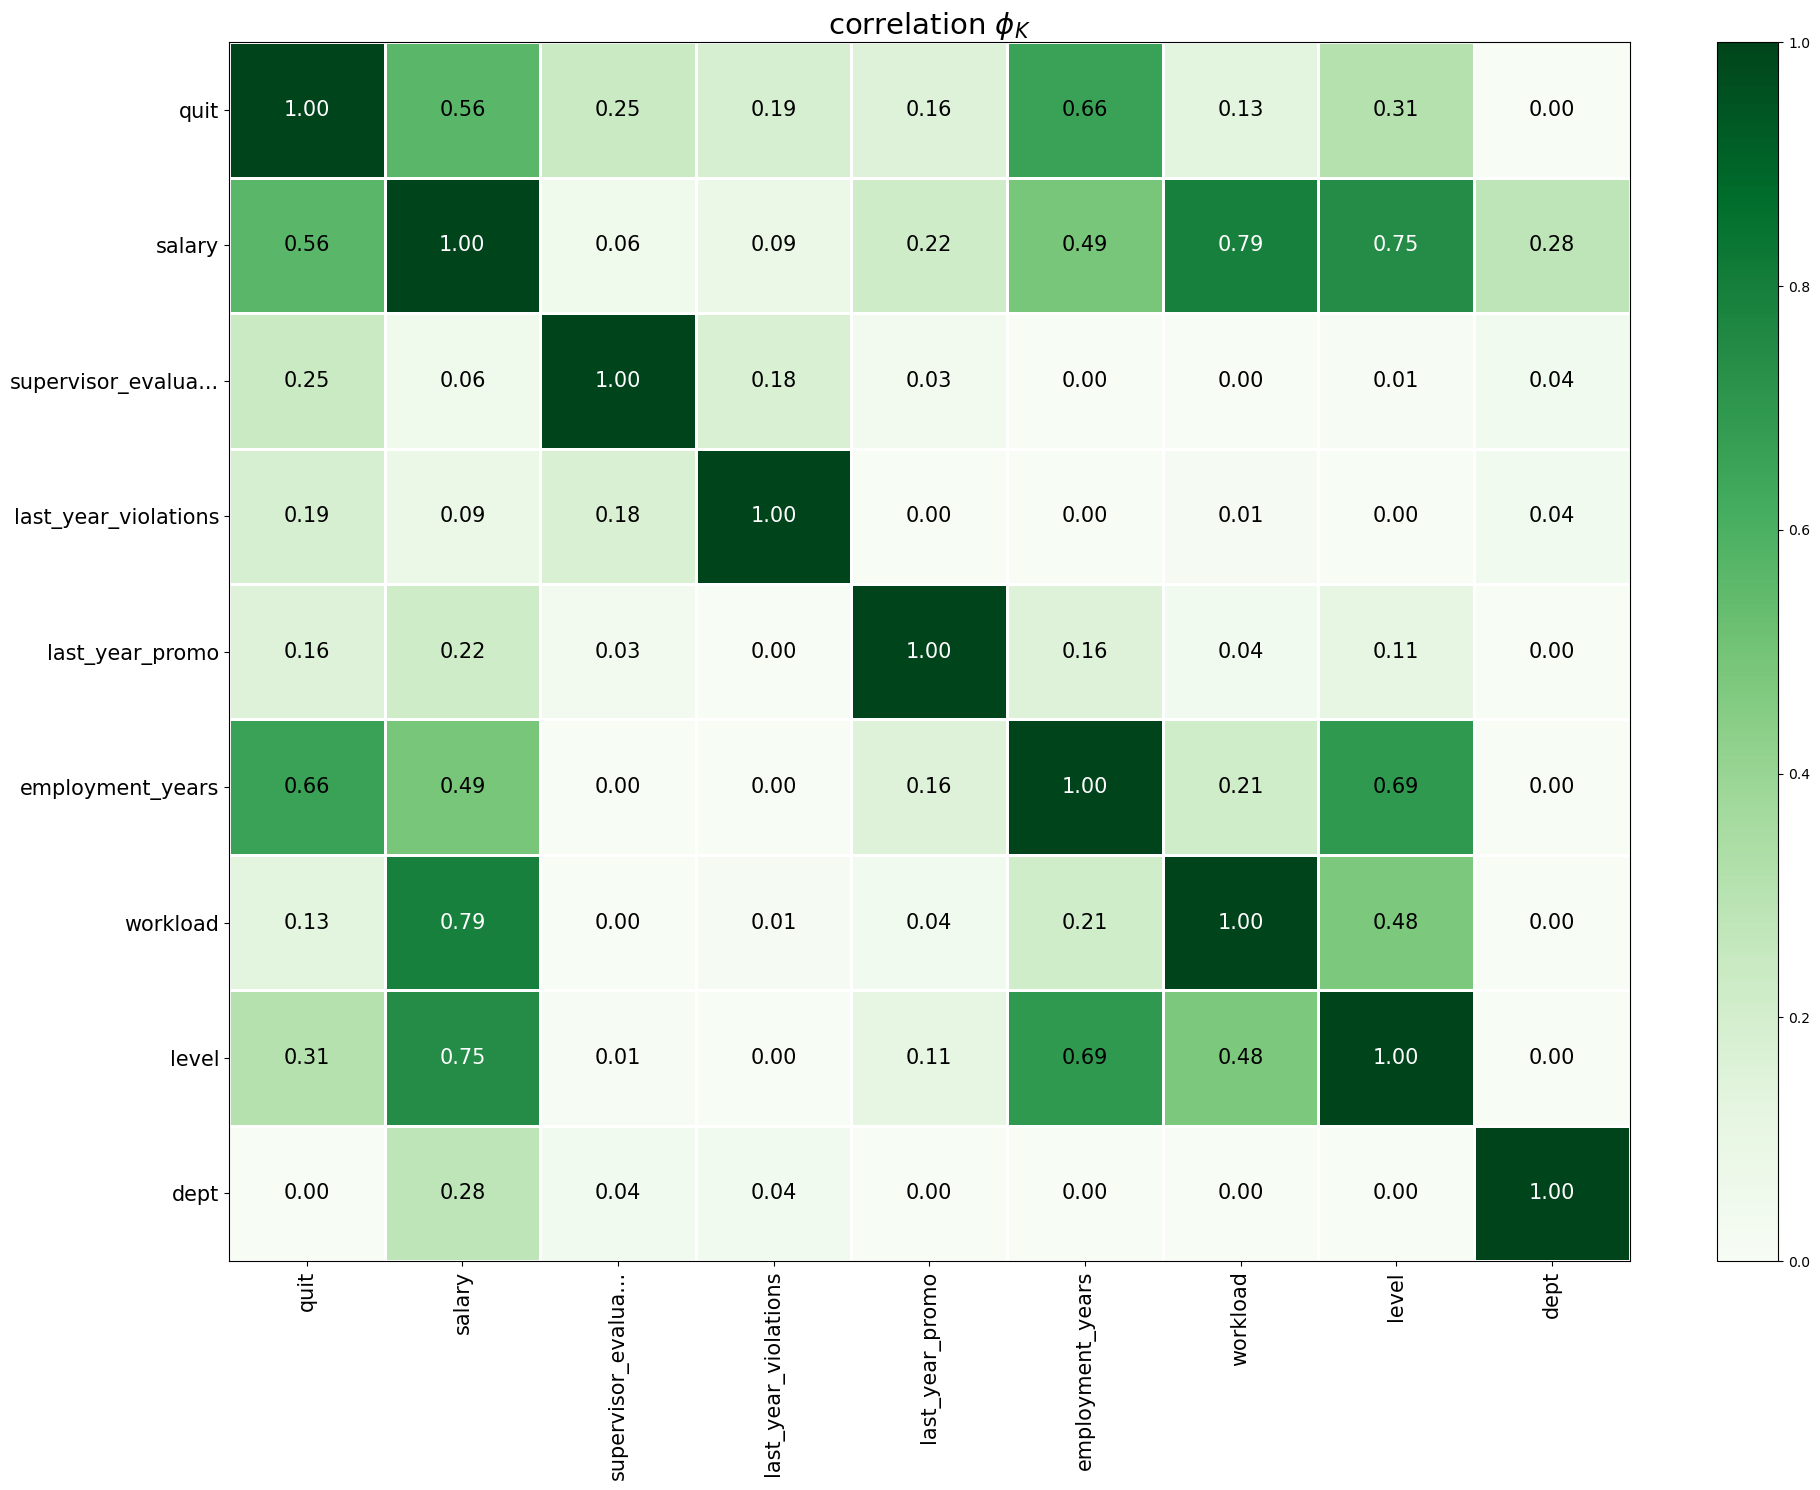

In [181]:
phik_overview = phik_matrix(df_train_quit,interval_cols=interval_cols)

plot_correlation_matrix( phik_overview.values, x_labels=phik_overview.columns,y_labels=phik_overview.index,
                        vmin=0, vmax=1, 
                        color_map='Greens',
                        title=r'correlation $\phi_K$',
                        fontsize_factor=1.5, figsize=(20, 15))

* Значительная корреляция наблюдается между целевым признаком и признаком "Количество проработанных лет". Однако таких значений коэффициента корреляции недостаточно, чтобы говорить о необходимости устранения этих признаков.
* Высокая корреляция наблюдается между двумя входными признаками "Уровень загруженности","Зарплата". Однако значение коэффициента корреляции мало, для того, чтобы можно было говорить о мультиколлинеарности

Проведем корреляционный анализ данных тестового датасета

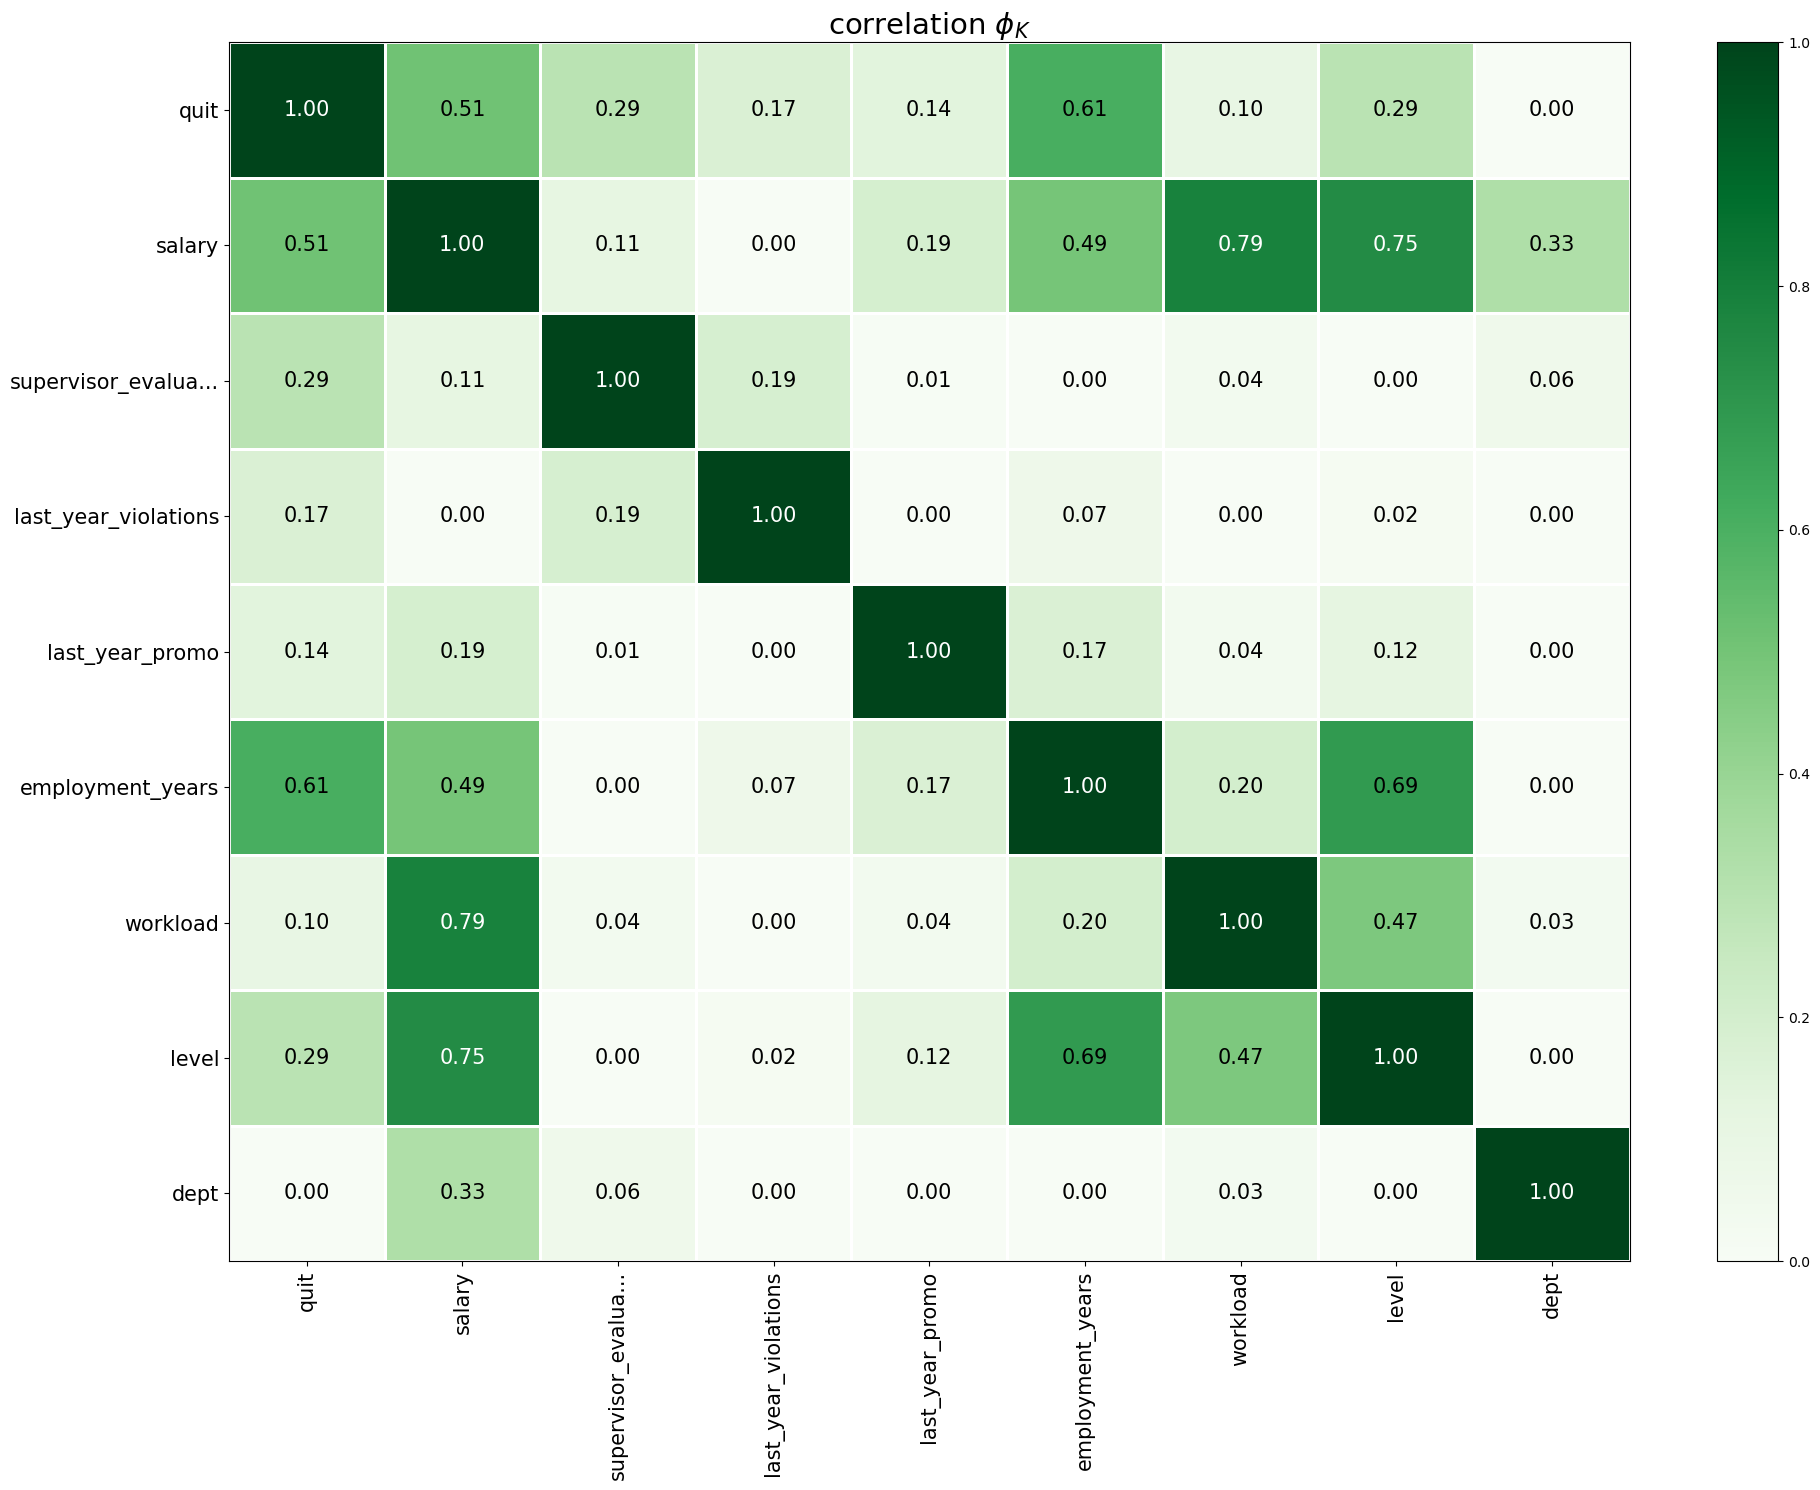

In [182]:
phik_overview = phik_matrix(df_test_features.join(df_test_target_quit),interval_cols=interval_cols)

plot_correlation_matrix( phik_overview.values, x_labels=phik_overview.columns,y_labels=phik_overview.index,
                        vmin=0, vmax=1, 
                        color_map='Greens',
                        title=r'correlation $\phi_K$',
                        fontsize_factor=1.5, figsize=(20, 15))

* Значительная корреляция наблюдается между целевым признаком и признаком "Количество проработанных лет". Однако таких значений коэффициента корреляции недостаточно, чтобы говорить о необходимости устранения этих признаков.
* Высокая корреляция наблюдается между двумя входными признаками "Уровень загруженности","Зарплата". Однако значение коэффициента корреляции мало, для того, чтобы можно было говорить о мультиколлинеарности

**Вывод**

В результате корреляционного анализа данных не было выявлено утечки целевого признака и мультиколлинеарности данных.

#### Подготовка пайплайнов предобработки

Закодируем целевой признак

In [183]:
label_encoder = LabelEncoder()

label_encoder.fit(y_train_quit) 
print(y_train_quit[:5])
y_train_quit = label_encoder.transform(y_train_quit)
y_test_quit = label_encoder.transform(y_test_quit)
y_train_quit[:5]

id
723290     no
814010     no
155091     no
257132    yes
910140     no
Name: quit, dtype: object


array([0, 0, 0, 1, 0])

LabelEncoder закодировл целевую переменную следующим образом

* Не уволился - 0
* Уволился - 1

Подготовим списки названий столбцов для последующей обработки

In [184]:
num_columns = ['salary','job_satisfaction_rate']


ohe_columns = ['dept','level','workload']

ord_columns = ['last_year_promo','last_year_violations']

Создадим пайплайн предобработки столбцов с OHE кодированием

In [185]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 

Создадим пайплайн предобработки столбцов с Ordinal кодированием

In [186]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Создадим пайплайн, объединяющий шаги предбработки

In [187]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False
) 

**Вывод**

* На данном шаге были подготовлены пайплайны для обработки данных перед обучением

### Обучение модели

#### Нахождение оптимальной модели

Создадим финальный пайплайн, состоящий из шагов по подготовки данных и обучению модели

In [188]:
pipe_final = Pipeline([ ('preprocessor', data_preprocessor),
                        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))])

Зададим словарь с различными моделями и гиперпараметрами для перебора

In [189]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'], 
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf':range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'], 
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,probability=True)],
        'models__kernel': ['linear','rbf','sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,penalty = 'l1',solver='liblinear',class_weight='balanced')],
        'models__C':[0.1,0.2,0.3,0.5,1,5,10,20],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }
] 

Для поиска лучшей модели будем использовать рандомизированный поиск с метрикой roc-auc

In [190]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50
)
randomized_search.fit(X_train_quit, y_train_quit)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('\nМетрика лучшей модели на кросс-валидации:', round(randomized_search.best_score_,2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'level',
                                                   'workload']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_bef

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


Наилучшей моделью оказалась модель дерева решений для задачи классификации. 

Проверим модель на метрику roc-auc на тестовых данных

In [191]:
X_train_new_quit = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train_quit)
X_test_new_quit = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test_quit)
X_train_new_quit = pd.DataFrame(X_train_new_quit,columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
X_test_new_quit = pd.DataFrame(X_test_new_quit,columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())

model_quit = randomized_search.best_estimator_.named_steps['models']
model_quit.fit(X_train_new_quit,y_train_quit)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,6
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Сделаем прогноз и посчитаем значение метрики

In [192]:
y_pred_prob = model_quit.predict_proba(X_test_new_quit)
print(f'Значение метрики roc-auc на тестовой выборке {round(roc_auc_score(y_test_quit,y_pred_prob[:,1]),2)}')

Значение метрики roc-auc на тестовой выборке 0.92


Полученное значение метрики удовлетворяет условию задания

**Выводы**

* С помощью метода рандомизированного поиска была найдена модель дающее наилучшее значение метрика "roc_auc"
* Наилучшей моделью оказалась модель дерева решений для задачи классификации
* Лучшее значение метрики roc_auc на кросс-валидации составило 0.9
* Лучшее значение метрики roc_auc на тестовой выборке составило 0.92

**Проверка на адекватность**

In [193]:
model_dum_class = DummyClassifier(random_state=RANDOM_STATE,strategy='most_frequent')

In [194]:
model_dum_class.fit(X_train_new_quit, y_train_quit)

,strategy,'most_frequent'
,random_state,42
,constant,None


In [195]:
y_pred_prob = model_dum_class.predict_proba(X_test_new_quit)
print(f'Значение метрики roc_auc на тестовой выборке {round(roc_auc_score(y_test_quit,y_pred_prob[:,1]),2)}')

Значение метрики roc_auc на тестовой выборке 0.5


Модель делающая константные предсказания даёт много меньшее значение метрики roc-auc, чем найденная модель

#### Исследование важности признаков модели

Построим Shap график для того, чтобы оценить вклад признаков в предсказание увольнение сотрудника.

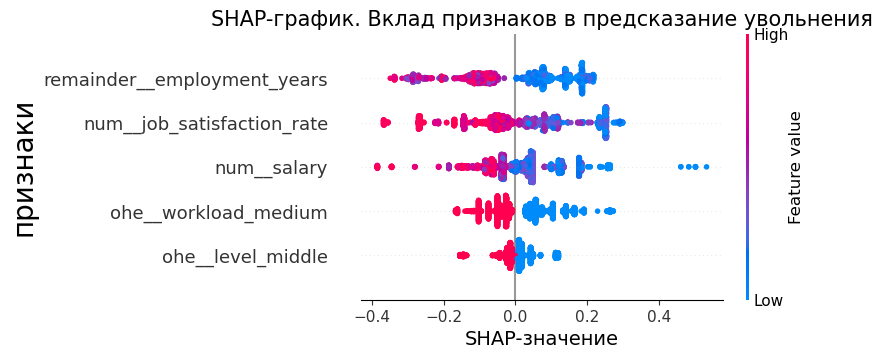

In [196]:
fig, ax = plt.gcf(), plt.gca()

explainer = shap.Explainer(model_quit,X_test_new_quit)
shap_values = explainer.shap_values(X_test_new_quit)
shap_values_class = shap_values[:,:,1]
shap.summary_plot(shap_values_class, X_test_new_quit,show=False,max_display=5)

ax.set_title('SHAP-график. Вклад признаков в предсказание увольнения', fontdict={"size":15})
ax.set_xlabel("SHAP-значение", fontsize=14)
ax.set_ylabel("признаки", fontsize=20)
plt.show()

Данный график показывает, что перечилсенные ниже признаки влияют следующим образом

* Удовлетворённость работой. Низкое значение - выше вероятность, что сотрудник уволится
* Количество проработанных лет. Низкое значение - выше вероятность, что сотрудник уволится
* Уровень нагрузки. Если уровень нагрузки не медиум, то высока вероятность увольнения
* Зарплата. Низкое значение - высокая вероятность увольнения
* Уровень должности Миддл. Если сотрудник не обладает уровнем должности Миддл, то у него высокая вероятность увольнения

Построим график показывающий сумму абсолютных shap значений, для того, чтобы понять насколько сильно каждый признак делает вклад в предсказание увольнения сотрудника

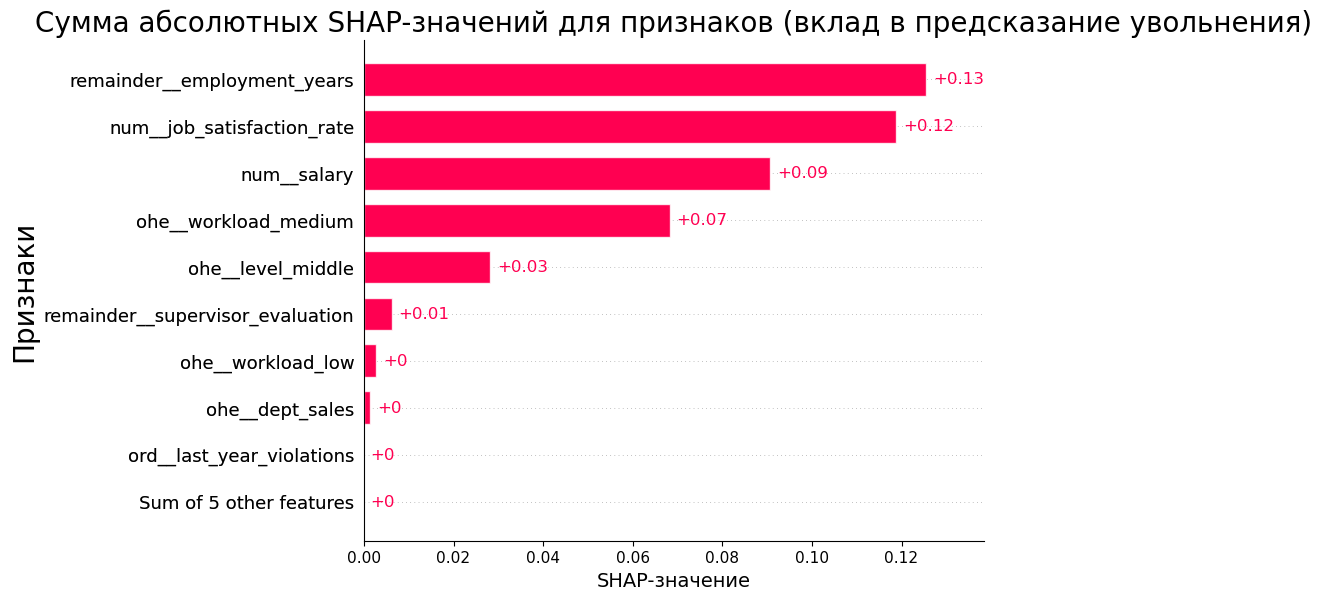

In [197]:
fig, ax = plt.gcf(), plt.gca()

shap_values_class_1 = shap_values[:, :, 1] 
shap_explanation = shap.Explanation(values=shap_values_class_1,  
                                    feature_names=X_test_new_quit.columns)


fig, ax = plt.gcf(), plt.gca()

shap.plots.bar(shap_explanation, show=False)


ax.set_title('Сумма абсолютных SHAP-значений для признаков (вклад в предсказание увольнения)', fontdict={"size":20})
ax.set_xlabel("SHAP-значение", fontsize=14)
ax.set_ylabel("Признаки", fontsize=20)

plt.show()

Как можно заметить по графику, наибольшее влияние на предсказание оказывают пять признаков:
1) Уровень удовлетворённости работой
2) Количество лет в компании
3) Средний ли уровень загруженности работника
4) Зарплата работника
5) Является ли сотрудник уровня миддл

**Вывод**

Наибольшее влияние на предсказание класса влияют пять признаков:

* Удовлетворённость работой. Низкое значение - выше вероятность, что сотрудник уволится
* Количество проработанных лет. Низкое значение - выше вероятность, что сотрудник уволится
* Уровень нагрузки. Если уровень нагрузки не медиум, то высока вероятность увольнения
* Зарплата. Низкое значение - высокая вероятность увольнения
* Уровень должности Миддл. Если сотрудник не обладает уровнем должности Миддл, то у него высокая вероятность увольнения

### Выводы по второй задаче и рекомендации бизнесу

1. **Загрузка данных.** Были загружены данные. Было произведено первичное ознакомление со структурой данных
2. **Предобработка данных.** Таблицы были проанализированы на наличие пропусков, дубликатов и неявных дубликатов. Были устранены проблемы в данных.
3. **Исследовательский анализ данных**

* Было выяснено, что уровень удовлетворённости влияет на количество увольнений.
* Был проведён графический анализ всех признаков из теренировочного и тестового датасетов.
* Были определены признаки подлежащие кодированию и масштабированию
* Был составлен портрет сотрудника, имеющего высокую вероятность увольнения:

    * Низкий уровень нагруженности
    * Должность: Джуниор
    * Низкий уровень зарплаты
    * Нарушал трудовой договор
    * Первый год работы
    * Низкая оценка руководителем

Наибольшая вероятность увольнения наблюдается в отделе продаж.

    
    
4. **Добавление признака**. Был добавлен признак удовлетворённости работой сотрудников
5. **Подготовка данных**.Были подготовлены пайплайны для обработки данных перед обучением
6. **Обучение модели**. 

* С помощью метода рандомизированного поиска была найдена модель дающее наилучшее значение метрика "roc_auc"
* Наилучшей моделью оказалась модель дерева решений для задачи классификации
* Лучшее значение метрики roc_auc на кросс-валидации составило 0.9
* Лучшее значение метрики roc_auc на тестовой выборке составило 0.92

Наибольшее влияние на предсказание класса влияют пять признаков:

* Удовлетворённость работой. Низкое значение - выше вероятность, что сотрудник уволится
* Количество проработанных лет. Низкое значение - выше вероятность, что сотрудник уволится
* Уровень нагрузки. Если уровень нагрузки не медиум, то высока вероятность увольнения
* Зарплата. Низкое значение - высокая вероятность увольнения
* Уровень должности Миддл. Если сотрудник не обладает уровнем должности Миддл, то у него высокая вероятность увольнения


**Рекомендации бизнесу**

Для минимизации количества увольнений необходимо рекомендованы к применения следующие действия

**Повышение удовлетворённости работой:**

* Разработайте программы мотивации и поощрения, которые бы способствовали высокой вовлеченности сотрудников.

**Улучшение карьерных перспектив и повышение квалификации:**

* Внедрите чёткую карьерную лестницу, которая позволяет сотрудникам видеть перспективы и ясно понимать, как можно достичь уровня Миддл и выше.

**Управление уровнем нагрузки:**

* Определите, какие задачи должны быть оптимизированы или перераспределены, чтобы избежать неоптимального распределения работы

**Увеличение зарплаты:**

* Регулярно пересматривайте зарплаты сотрудников в зависимости от их уровня и опыта. Предлагайте конкурентоспособные зарплаты, которые соответствуют рыночным условиям.

**Поддержка сотрудников на уровне должности Джуниор:**

* Создайте условия для развития, которые позволят сотрудникам уровня Джуниор чувствовать себя членами команды, а также предложите возможности для роста и развития.

## Общий вывод

***Задача 1***

1. **Загрузка данных.** Все данные были загружены. Произведено первичное ознакомление с данными.
2. **Предобработка данных.** Таблицы были проанализированы на наличие пропусков, дубликатов и неявных дубликатов. Были устранены проблемы в данных. 
3. **Исследовательский анализ данных.** 

* Был проведён графический анализ всех признаков из теренировочного и тестового датасетов.
* Были определены признаки подлежащие кодированию и масштабированию

4. **Подготовка данных** 

* Проведен корреляционный анализ таблицы для моделирования
* Мультиколлинеарности и утечки целевого признака не обнаружено
* На данном шаге были подготовлены пайплайны для обработки данных перед обучением

5. **Обучение моделей**

* С помощью метода рандомизированного поиска была найдена модель дающее наилучшее значение метрика SMAPE
* Наилучшей моделью оказалась модель дерева решений для задачи регрессии
* Лучшее значение метрики SMAPE на кросс-валидации составило 15.25
* Лучшее значение метрики SMAPE на тестовой выборке составило 13.55


Анализ признаков показывает, что призники наиболее влияющие на удовлетворённость сотрудника работой:

1) Оценка сотрудника руководителем. Высокие значения соответсвую высокой уровнем удовлетворенности

2) Количество лет, которые сотрудник проработал в компании. Высокие значения соответсвуют высоким уровнем удовлетворенности

3) Зарплата. Высокие значения соотвествуют высокой удовлетворённости сотрудника

**Рекомендации бизнесу для увеличения уровня удовлетворённости сотрудников работой**


**Оценка сотрудника руководителем**

* Подчёркивайте достижения сотрудников и давайте рекомендации для дальнейшего роста. Это помогает сотрудникам чувствовать, что их усилия замечаются и оцениваются по достоинству.

**Количество лет работы в компании**

* Разработайте программы, которые будут поощрять долгосрочную работу в компании. Например, бонусы за определённый стаж работы

**Зарплата** 

* Регулярно проверяйте рыночные ставки и пересматривайте зарплаты сотрудников в зависимости от их вклада, опыта и рынка. Даже небольшие корректировки могут значительно повысить удовлетворённость.


***Задача 2***

1. **Загрузка данных.** Были загружены данные. Было произведено первичное ознакомление со структурой данных
2. **Предобработка данных.** Таблицы были проанализированы на наличие пропусков, дубликатов и неявных дубликатов. Были устранены проблемы в данных.
3. **Исследовательский анализ данных**

* Было выяснено, что уровень удовлетворённости влияет на количество увольнений.
* Был проведён графический анализ всех признаков из теренировочного и тестового датасетов.
* Были определены признаки подлежащие кодированию и масштабированию
* Был составлен портрет сотрудника, имеющего высокую вероятность увольнения:

    * Низкий уровень нагруженности
    * Должность: Джуниор
    * Низкий уровень зарплаты
    * Нарушал трудовой договор
    * Первый год работы
    * Низкая оценка руководителем

Наибольшая доля увольнения наблюдается в отделе продаж.

    
    
4. **Добавление признака**. Был добавлен признак удовлетворённости работой сотрудников
5. **Подготовка данных**.Были подготовлены пайплайны для обработки данных перед обучением
6. **Обучение модели**. 

* С помощью метода рандомизированного поиска была найдена модель дающее наилучшее значение метрика "roc_auc"
* Наилучшей моделью оказалась модель дерева решений для задачи классификации
* Лучшее значение метрики roc_auc на кросс-валидации составило 0.9
* Лучшее значение метрики roc_auc на тестовой выборке составило 0.92

Наибольшее влияние на предсказание класса влияют пять признаков:

* Удовлетворённость работой. Низкое значение - выше вероятность, что сотрудник уволится
* Количество проработанных лет. Низкое значение - выше вероятность, что сотрудник уволится
* Уровень нагрузки. Если уровень нагрузки не медиум, то высока вероятность увольнения
* Зарплата. Низкое значение - высокая вероятность увольнения
* Уровень должности Миддл. Если сотрудник не обладает уровнем должности Миддл, то у него высокая вероятность увольнения

**Рекомендации бизнесу для минимизации количества увольнений**

**Повышение удовлетворённости работой:**

* Разработайте программы мотивации и поощрения, которые бы способствовали высокой вовлеченности сотрудников.

**Улучшение карьерных перспектив и повышение квалификации:**

* Внедрите чёткую карьерную лестницу, которая позволяет сотрудникам видеть перспективы и ясно понимать, как можно достичь уровня Миддл и выше.

**Управление уровнем нагрузки:**

* Определите, какие задачи должны быть оптимизированы или перераспределены, чтобы избежать неоптимального распределения работы

**Увеличение зарплаты:**

* Регулярно пересматривайте зарплаты сотрудников в зависимости от их уровня и опыта. Предлагайте конкурентоспособные зарплаты, которые соответствуют рыночным условиям.

**Поддержка сотрудников на уровне должности Джуниор:**

* Создайте условия для развития, которые позволят сотрудникам уровня Джуниор чувствовать себя членами команды, а также предложите возможности для роста и развития.